### Phase 1: Data Exploration & Feature Engineering
#### 1.1 Data Loading & Initial Exploration
##### Import necessary libraries

In [ ]:
!pip install "numpy<2.0" --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

##### Load Datasets

In [3]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")

# Load datasets
campaigns_df = pd.read_csv('cee-dataset/campaigns.csv')
customers_df = pd.read_csv('cee-dataset/customers.csv')
engagements_df = pd.read_csv('cee-dataset/engagements.csv')
interactions_df = pd.read_csv('cee-dataset/interactions.csv')

##### Data Overview
##### Checks basic statistics of all data types in csv's accordingly.

In [4]:
print("\n1. Dataset Shapes:")
print(f"   - campaigns.csv: {campaigns_df.shape}")
print(f"   - customers.csv: {customers_df.shape}")
print(f"   - engagements.csv: {engagements_df.shape}")
print(f"   - interactions.csv: {interactions_df.shape}")

print("\n2. Campaigns Dataset Overview:")
print(campaigns_df.head())
print(f"\n   Data types:\n{campaigns_df.dtypes}")
print(f"\n   Missing values:\n{campaigns_df.isnull().sum()}")
print(f"\n   Unique campaigns: {campaigns_df['campaign_id'].nunique()}")

print("\n3. Customers Dataset Overview:")
print(customers_df.head())
print(f"\n   Data types:\n{customers_df.dtypes}")
print(f"\n   Missing values:\n{customers_df.isnull().sum()}")
print(f"\n   Unique customers: {customers_df['customer_id'].nunique()}")
print(f"\n   Tier distribution:\n{customers_df['tier'].value_counts()}")
print(f"\n   Preferred channel distribution:\n{customers_df['preferred_channel'].value_counts()}")
print(f"\n   Active customers: {customers_df['is_active'].sum()} / {len(customers_df)}")

print("\n4. Engagements Dataset Overview:")
print(engagements_df.head())
print(f"\n   Data types:\n{engagements_df.dtypes}")
print(f"\n   Missing values:\n{engagements_df.isnull().sum()}")
print(f"\n   Date range: {engagements_df['month'].min()} to {engagements_df['month'].max()}")

print("\n5. Interactions Dataset Overview:")
print(interactions_df.head())
print(f"\n   Data types:\n{interactions_df.dtypes}")
print(f"\n   Missing values:\n{interactions_df.isnull().sum()}")
print(f"\n   Unique customers in interactions: {interactions_df['customer_id'].nunique()}")
print(f"\n   Unique campaigns in interactions: {interactions_df['campaign_id'].nunique()}")
print(f"\n   Conversion rate: {interactions_df['converted'].mean():.4f} ({interactions_df['converted'].sum()} conversions out of {len(interactions_df)} interactions)")

# Check for overlapping keys
print("\n6. Key Relationships:")
print(f"   Campaign IDs in campaigns: {sorted(campaigns_df['campaign_id'].unique())}")
print(f"   Campaign IDs in interactions: {sorted(interactions_df['campaign_id'].unique())}")
print(f"   Campaign IDs match: {set(campaigns_df['campaign_id']) == set(interactions_df['campaign_id'])}")
print(f"   Customer IDs in customers: {customers_df['customer_id'].nunique()}")
print(f"   Customer IDs in interactions: {interactions_df['customer_id'].nunique()}")
print(f"   Customers in interactions but not in customers table: {len(set(interactions_df['customer_id']) - set(customers_df['customer_id']))}")

# Basic statistics
print("\n7. Basic Statistics:")
print("\n   Interactions - Conversion Statistics:")
print(f"   - Total interactions: {len(interactions_df)}")
print(f"   - Opened: {interactions_df['opened'].sum()} ({interactions_df['opened'].mean():.2%})")
print(f"   - Clicked: {interactions_df['clicked'].sum()} ({interactions_df['clicked'].mean():.2%})")
print(f"   - Converted: {interactions_df['converted'].sum()} ({interactions_df['converted'].mean():.2%})")
print(f"   - Total revenue: RM {interactions_df['revenue_rm'].sum():,.2f}")
print(f"   - Average revenue per conversion: RM {interactions_df[interactions_df['converted']==1]['revenue_rm'].mean():,.2f}")


1. Dataset Shapes:
   - campaigns.csv: (10, 7)
   - customers.csv: (5000, 7)
   - engagements.csv: (30, 8)
   - interactions.csv: (30000, 13)

2. Campaigns Dataset Overview:
   campaign_id campaign_name   channel   objective launch_date  audience_size  \
0          201        CEE_01  App Push      Upsell  2025-07-01           5111   
1          202        CEE_02  WhatsApp  Cross-Sell  2025-07-08          41249   
2          203        CEE_03  App Push   Retention  2025-07-15          22747   
3          204        CEE_04  App Push  Cross-Sell  2025-07-22          40662   
4          205        CEE_05     Email      Upsell  2025-07-29           8325   

   budget_rm  
0     131428  
1      40255  
2      16648  
3      33728  
4      93079  

   Data types:
campaign_id       int64
campaign_name    object
channel          object
objective        object
launch_date      object
audience_size     int64
budget_rm         int64
dtype: object

   Missing values:
campaign_id      0
campaign_na

#### 1.2 Dataset Joining
##### Handle data sanitisation with _interactions.csv_ as the base and joins with _(customer × campaign level data)_.

In [5]:
# Convert date columns to datetime for proper handling
interactions_df['send_date'] = pd.to_datetime(interactions_df['send_date'])
customers_df['relationship_start'] = pd.to_datetime(customers_df['relationship_start'])
campaigns_df['launch_date'] = pd.to_datetime(campaigns_df['launch_date'])

print("\nStep 1: Starting with interactions.csv as base table")
print(f"   Base table shape: {interactions_df.shape}")
print(f"   This represents individual customer-campaign interactions (granular level)")

print("\nStep 2: Joining with customers.csv on customer_id")
print(f"   Customers to join: {customers_df.shape[0]}")
print(f"   Expected join: LEFT JOIN (keep all interactions, add customer attributes)")

modeling_df = interactions_df.merge(
    customers_df,
    on='customer_id',
    how='left',
    suffixes=('', '_customer')
)

print(f"   After join shape: {modeling_df.shape}")
print(f"   New columns added: {set(modeling_df.columns) - set(interactions_df.columns)}")

# Check for missing customer data
missing_customers = modeling_df[modeling_df['tier'].isna()]
if len(missing_customers) > 0:
    print(f"   WARNING: {len(missing_customers)} interactions have no matching customer data")
    print(f"   Customer IDs with missing data: {missing_customers['customer_id'].unique()[:10]}")
else:
    print("   ✓ All interactions have matching customer data")

print("\nStep 3: Joining with campaigns.csv on campaign_id")
print(f"   Campaigns to join: {campaigns_df.shape[0]}")

modeling_df = modeling_df.merge(
    campaigns_df,
    on='campaign_id',
    how='left',
    suffixes=('', '_campaign')
)

print(f"   After join shape: {modeling_df.shape}")
print(f"   New columns added: {set(modeling_df.columns) - set(modeling_df.columns) if 'campaign_name' in modeling_df.columns else 'campaign_name, channel_campaign, objective, launch_date, audience_size, budget_rm'}")

# Check for missing campaign data
missing_campaigns = modeling_df[modeling_df['campaign_name'].isna()]
if len(missing_campaigns) > 0:
    print(f"   WARNING: {len(missing_campaigns)} interactions have no matching campaign data")
else:
    print("   ✓ All interactions have matching campaign data")

# Step 4: Handle duplicate column names (channel appears in both interactions and campaigns)
print("\nStep 4: Handling duplicate column names")
if 'channel' in interactions_df.columns and 'channel' in campaigns_df.columns:
    # Keep channel from interactions (actual channel used) and rename campaign channel if needed
    if 'channel_campaign' in modeling_df.columns:
        print("   Channel column from campaigns renamed to 'channel_campaign'")
    else:
        # Rename for clarity
        modeling_df = modeling_df.rename(columns={'channel': 'channel_used'})
        if 'channel_campaign' in campaigns_df.columns:
            pass
        else:
            # Create channel_campaign from campaigns
            channel_mapping = campaigns_df.set_index('campaign_id')['channel'].to_dict()
            modeling_df['channel_campaign'] = modeling_df['campaign_id'].map(channel_mapping)
            print("   Created 'channel_campaign' from campaigns table")

# Step 5: Display final joined dataset structure
print("\nStep 5: Final Modeling Dataset Structure")
print(f"   Final shape: {modeling_df.shape}")
print(f"   Columns ({len(modeling_df.columns)}):")
for i, col in enumerate(modeling_df.columns, 1):
    print(f"   {i:2d}. {col}")

print("\nStep 6: Sample of joined data")
print(modeling_df.head(10))

print("\nStep 7: Data quality checks")
print(f"   Total rows: {len(modeling_df)}")
print(f"   Missing values per column:")
missing_summary = modeling_df.isnull().sum()
print(missing_summary[missing_summary > 0] if missing_summary.sum() > 0 else "   ✓ No missing values")

# Check for duplicate interactions
duplicates = modeling_df.duplicated(subset=['customer_id', 'campaign_id', 'send_date']).sum()
print(f"   Duplicate interactions (same customer, campaign, date): {duplicates}")


Step 1: Starting with interactions.csv as base table
   Base table shape: (30000, 13)
   This represents individual customer-campaign interactions (granular level)

Step 2: Joining with customers.csv on customer_id
   Customers to join: 5000
   Expected join: LEFT JOIN (keep all interactions, add customer attributes)
   After join shape: (30000, 19)
   New columns added: {'preferred_channel', 'relationship_start', 'tier', 'region', 'age', 'is_active'}
   ✓ All interactions have matching customer data

Step 3: Joining with campaigns.csv on campaign_id
   Campaigns to join: 10
   After join shape: (30000, 25)
   New columns added: set()
   ✓ All interactions have matching campaign data

Step 4: Handling duplicate column names
   Channel column from campaigns renamed to 'channel_campaign'

Step 5: Final Modeling Dataset Structure
   Final shape: (30000, 25)
   Columns (25):
    1. interaction_id
    2. customer_id
    3. campaign_id
    4. send_date
    5. channel
    6. device_type
    

#### 1.3 - Feature Engineering
##### Summarise

In [6]:
# Create a copy to avoid modifying the original
df = modeling_df.copy()

print(f"\nStarting feature engineering on {len(df)} rows...")
print(f"Initial columns: {len(df.columns)}")

# ============================================================================
# 1. TEMPORAL FEATURES
# ============================================================================
print("\n1. Creating Temporal Features...")

# Customer tenure (days from relationship_start to send_date)
df['customer_tenure_days'] = (df['send_date'] - df['relationship_start']).dt.days
df['customer_tenure_months'] = df['customer_tenure_days'] / 30.44  # Average days per month
df['customer_tenure_years'] = df['customer_tenure_days'] / 365.25

# Days since campaign launch
df['days_since_campaign_launch'] = (df['send_date'] - df['launch_date']).dt.days

# Extract time-based features from send_date
df['send_year'] = df['send_date'].dt.year
df['send_month'] = df['send_date'].dt.month
df['send_day'] = df['send_date'].dt.day
df['send_day_of_week'] = df['send_date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['send_day_name'] = df['send_date'].dt.day_name()
df['send_is_weekend'] = (df['send_day_of_week'] >= 5).astype(int)

# Send hour features (already exists, but create binned versions)
df['send_hour_morning'] = ((df['send_hour'] >= 6) & (df['send_hour'] < 12)).astype(int)
df['send_hour_afternoon'] = ((df['send_hour'] >= 12) & (df['send_hour'] < 18)).astype(int)
df['send_hour_evening'] = ((df['send_hour'] >= 18) & (df['send_hour'] < 22)).astype(int)
df['send_hour_night'] = ((df['send_hour'] >= 22) | (df['send_hour'] < 6)).astype(int)

print(f"   ✓ Created {len([c for c in df.columns if 'tenure' in c or 'send_' in c or 'days_since' in c])} temporal features")

# ============================================================================
# 2. ENGAGEMENT HISTORY FEATURES
# ============================================================================
print("\n2. Creating Engagement History Features...")

# prior_engagements_90d already exists, but let's create additional historical features
# Calculate customer-level historical metrics
customer_history = interactions_df.groupby('customer_id').agg({
    'opened': ['sum', 'mean'],
    'clicked': ['sum', 'mean'],
    'converted': ['sum', 'mean'],
    'revenue_rm': ['sum', 'mean'],
    'interaction_id': 'count'
}).reset_index()

customer_history.columns = ['customer_id', 
                           'hist_total_opens', 'hist_open_rate',
                           'hist_total_clicks', 'hist_click_rate',
                           'hist_total_conversions', 'hist_conversion_rate',
                           'hist_total_revenue', 'hist_avg_revenue',
                           'hist_total_interactions']

# Merge historical features (excluding current interaction)
# We'll use a left merge and then subtract current interaction values
df = df.merge(customer_history, on='customer_id', how='left')

# Adjust for current interaction (subtract current values from totals)
df['hist_total_opens'] = df['hist_total_opens'] - df['opened']
df['hist_total_clicks'] = df['hist_total_clicks'] - df['clicked']
df['hist_total_conversions'] = df['hist_total_conversions'] - df['converted']
df['hist_total_interactions'] = df['hist_total_interactions'] - 1

# Recalculate rates based on prior interactions
df['hist_open_rate'] = np.where(df['hist_total_interactions'] > 0,
                                df['hist_total_opens'] / df['hist_total_interactions'],
                                0)
df['hist_click_rate'] = np.where(df['hist_total_interactions'] > 0,
                                 df['hist_total_clicks'] / df['hist_total_interactions'],
                                 0)
df['hist_conversion_rate'] = np.where(df['hist_total_interactions'] > 0,
                                      df['hist_total_conversions'] / df['hist_total_interactions'],
                                      0)

# prior_engagements_90d is already in the data
print(f"   ✓ Created historical engagement features")

# ============================================================================
# 3. CUSTOMER-CAMPAIGN ALIGNMENT FEATURES
# ============================================================================
print("\n3. Creating Customer-Campaign Alignment Features...")

# Channel preference match
df['channel_preference_match'] = (df['preferred_channel'] == df['channel']).astype(int)

# Tier-based features (encode as ordinal or create binary features)
tier_order = {'Bronze': 1, 'Silver': 2, 'Gold': 3}
df['tier_encoded'] = df['tier'].map(tier_order)

# Create binary tier indicators
df['is_bronze'] = (df['tier'] == 'Bronze').astype(int)
df['is_silver'] = (df['tier'] == 'Silver').astype(int)
df['is_gold'] = (df['tier'] == 'Gold').astype(int)

# Active status (already exists as is_active, but ensure it's int)
df['is_active'] = df['is_active'].astype(int)

print(f"   ✓ Created alignment features")

# ============================================================================
# 4. CAMPAIGN FEATURES
# ============================================================================
print("\n4. Creating Campaign Features...")

# Budget per customer (budget allocated per customer in audience)
df['budget_per_customer'] = df['budget_rm'] / df['audience_size']

# Objective encoding
objective_map = {'Upsell': 1, 'Cross-Sell': 2, 'Retention': 3, 'Awareness': 4}
df['objective_encoded'] = df['objective'].map(objective_map)

# Create binary objective indicators
for obj in df['objective'].unique():
    if pd.notna(obj):
        df[f'objective_{obj.lower().replace("-", "_")}'] = (df['objective'] == obj).astype(int)

# Campaign age (how old the campaign is when interaction happens)
df['campaign_age_days'] = (df['send_date'] - df['launch_date']).dt.days

print(f"   ✓ Created campaign features")

# ============================================================================
# 5. DEVICE & TIMING FEATURES
# ============================================================================
print("\n5. Creating Device & Timing Features...")

# Device type encoding
device_map = {'Mobile': 1, 'Desktop': 2}
df['device_encoded'] = df['device_type'].map(device_map)
df['is_mobile'] = (df['device_type'] == 'Mobile').astype(int)
df['is_desktop'] = (df['device_type'] == 'Desktop').astype(int)

# Region encoding (one-hot will be done later, but create encoded version)
region_map = {region: idx for idx, region in enumerate(df['region'].unique())}
df['region_encoded'] = df['region'].map(region_map)

print(f"   ✓ Created device and region features")

# ============================================================================
# 6. DERIVED FEATURES
# ============================================================================
print("\n6. Creating Derived Features...")

# Customer age group
df['age_group'] = pd.cut(df['age'], 
                         bins=[0, 30, 40, 50, 60, 100],
                         labels=['<30', '30-40', '40-50', '50-60', '60+'])

# Tenure groups
df['tenure_group'] = pd.cut(df['customer_tenure_days'],
                            bins=[0, 180, 365, 730, 1095, 10000],
                            labels=['<6m', '6m-1y', '1y-2y', '2y-3y', '3y+'])

# Prior engagement intensity
df['prior_engagement_high'] = (df['prior_engagements_90d'] >= df['prior_engagements_90d'].quantile(0.75)).astype(int)
df['prior_engagement_low'] = (df['prior_engagements_90d'] <= df['prior_engagements_90d'].quantile(0.25)).astype(int)

print(f"   ✓ Created derived categorical features")

# ============================================================================
# 7. INTERACTION FEATURES
# ============================================================================
print("\n7. Creating Interaction-Level Features...")

# Funnel position indicators (already have opened, clicked, converted)
# But create ratios
df['open_to_click_rate'] = np.where(df['opened'] > 0,
                                    df['clicked'] / df['opened'],
                                    0)
df['click_to_convert_rate'] = np.where(df['clicked'] > 0,
                                       df['converted'] / df['clicked'],
                                       0)

# Revenue per interaction (already exists as revenue_rm)
# But create binary for revenue > 0
df['has_revenue'] = (df['revenue_rm'] > 0).astype(int)

print(f"   ✓ Created interaction features")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 80)
print(f"Final dataset shape: {df.shape}")
print(f"Total features created: {df.shape[1] - modeling_df.shape[1]} new columns")
print(f"Total columns: {df.shape[1]}")

# List all feature categories
print("\nFeature Categories:")
print(f"  - Temporal features: {len([c for c in df.columns if 'tenure' in c or 'send_' in c or 'days_since' in c or 'campaign_age' in c])}")
print(f"  - Engagement history: {len([c for c in df.columns if 'hist_' in c or 'prior_' in c])}")
print(f"  - Customer-campaign alignment: {len([c for c in df.columns if 'channel_preference' in c or 'tier' in c or 'is_active' in c])}")
print(f"  - Campaign features: {len([c for c in df.columns if 'budget' in c or 'objective' in c or 'audience' in c])}")
print(f"  - Device & timing: {len([c for c in df.columns if 'device' in c or 'region' in c or 'hour' in c])}")
print(f"  - Derived features: {len([c for c in df.columns if 'group' in c or 'engagement' in c])}")
print(f"  - Interaction features: {len([c for c in df.columns if 'rate' in c or 'has_revenue' in c])}")

# Check for missing values
print("\nMissing Values Check:")
missing = df.isnull().sum()
missing_cols = missing[missing > 0]
if len(missing_cols) > 0:
    print(missing_cols)
else:
    print("  ✓ No missing values in engineered features")

# Display sample of engineered features
print("\nSample of engineered features:")
feature_cols = [c for c in df.columns if c not in modeling_df.columns or 
                c in ['customer_tenure_days', 'channel_preference_match', 'tier_encoded', 
                      'hist_conversion_rate', 'budget_per_customer']]
print(df[['customer_id', 'campaign_id', 'converted'] + feature_cols[:10]].head())


Starting feature engineering on 30000 rows...
Initial columns: 25

1. Creating Temporal Features...
   ✓ Created 16 temporal features

2. Creating Engagement History Features...
   ✓ Created historical engagement features

3. Creating Customer-Campaign Alignment Features...
   ✓ Created alignment features

4. Creating Campaign Features...
   ✓ Created campaign features

5. Creating Device & Timing Features...
   ✓ Created device and region features

6. Creating Derived Features...
   ✓ Created derived categorical features

7. Creating Interaction-Level Features...
   ✓ Created interaction features

FEATURE ENGINEERING SUMMARY
Final dataset shape: (30000, 71)
Total features created: 46 new columns
Total columns: 71

Feature Categories:
  - Temporal features: 18
  - Engagement history: 12
  - Customer-campaign alignment: 4
  - Campaign features: 9
  - Device & timing: 9
  - Derived features: 5
  - Interaction features: 6

Missing Values Check:
  ✓ No missing values in engineered feature

#### 1.4 - Exploratary Data Analysis


SECTION 1.4: EXPLORATORY DATA ANALYSIS

1. Conversion Rate Analysis by Segments...

1.1 Conversion by Tier:
        conversions  total  conversion_rate  rate_pct
tier                                                 
Gold             52   4624         0.011246  1.124567
Silver          134  11983         0.011183  1.118251
Bronze          118  13393         0.008811  0.881057


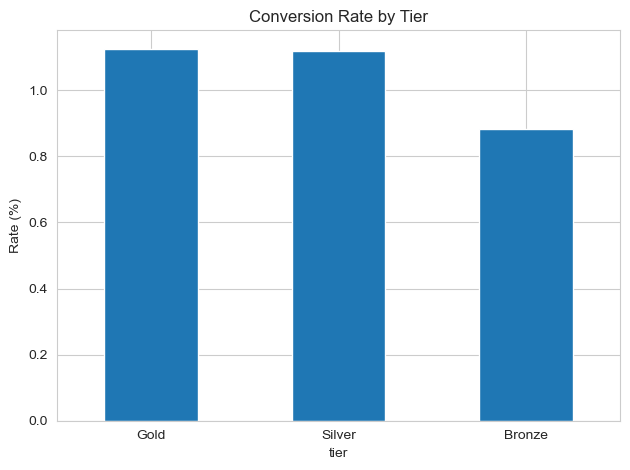


1.2 Conversion by Channel:
          conversions  total  conversion_rate  rate_pct
channel                                                
App Push          218  18070         0.012064  1.206419
Email              30   2969         0.010104  1.010441
WhatsApp           56   8961         0.006249  0.624930


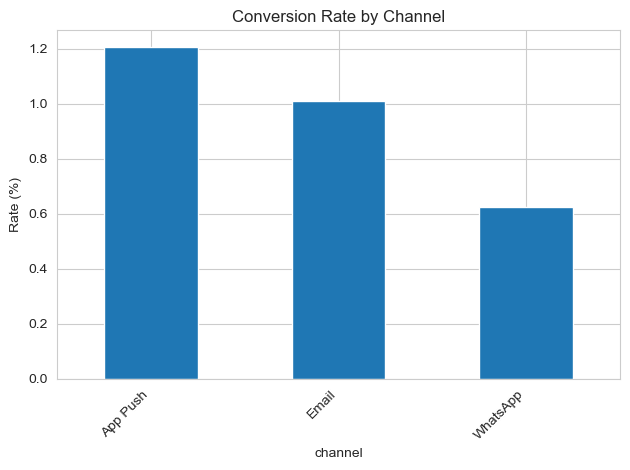


1.3 Conversion by Channel Match:
                          conversions  total  conversion_rate  rate_pct
channel_preference_match                                               
1                                  93   7754         0.011994  1.199381
0                                 211  22246         0.009485  0.948485


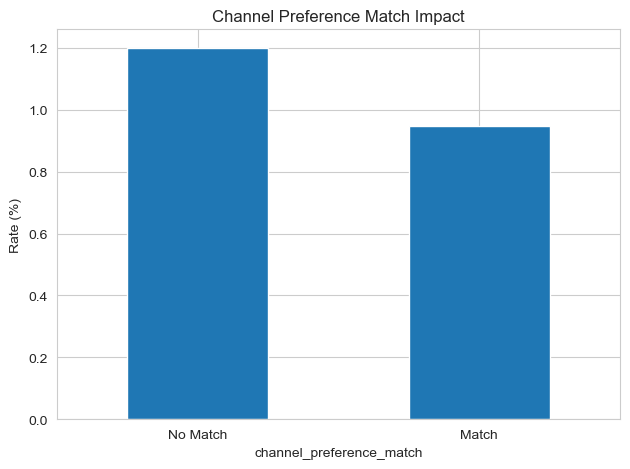


1.4 Conversion by Objective:
            conversions  total  conversion_rate  rate_pct
objective                                                
Upsell              105   9011         0.011652  1.165242
Cross-Sell          101   9018         0.011200  1.119982
Awareness            33   3005         0.010982  1.098170
Retention            65   8966         0.007250  0.724961


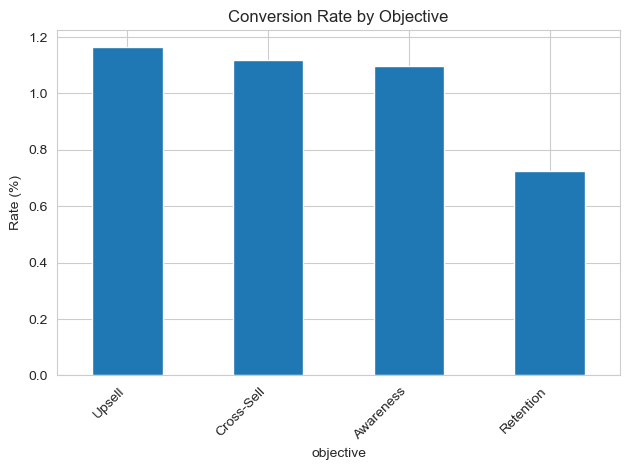


1.5 Conversion by Region:
               conversions  total  conversion_rate  rate_pct
region                                                      
Sabah/Sarawak           34   3094         0.010989  1.098901
KL/Selangor            116  10619         0.010924  1.092382
Others                  62   6034         0.010275  1.027511
Johor                   55   6104         0.009010  0.901048
Penang                  37   4149         0.008918  0.891781


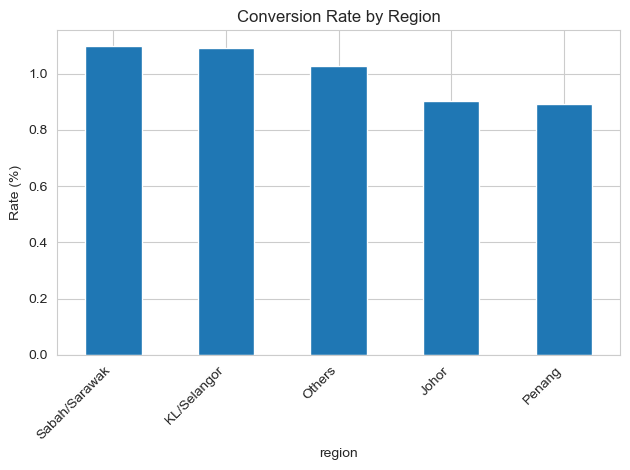


1.6 Conversion by Device:
             conversions  total  conversion_rate  rate_pct
device_type                                               
Desktop              106   9019         0.011753  1.175297
Mobile               198  20981         0.009437  0.943711

2. Distribution Analysis...


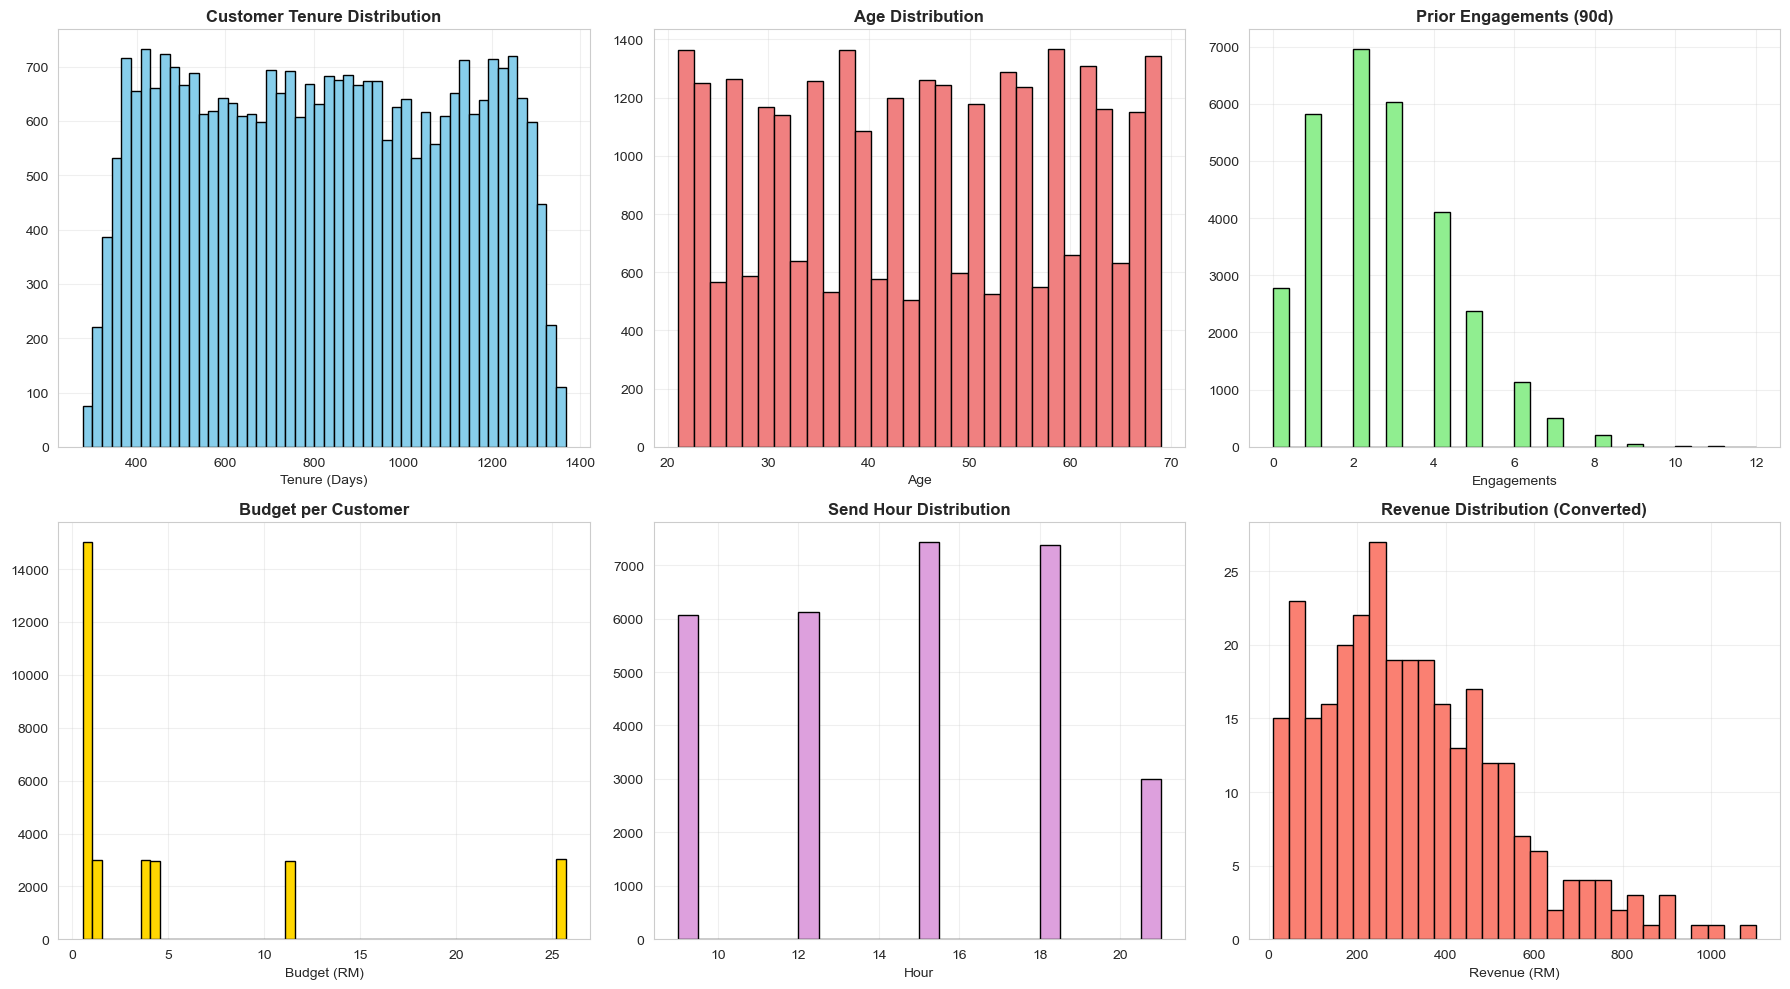


3. Correlation Analysis...

Top 10 Features Correlated with Conversion:
has_revenue                 1.000000
click_to_convert_rate       1.000000
open_to_click_rate          0.377062
hist_avg_revenue            0.329454
hist_total_revenue          0.314427
channel_preference_match    0.010967
device_encoded              0.010603
is_desktop                  0.010603
tier_encoded                0.010600
objective_upsell            0.009938
Name: converted, dtype: float64


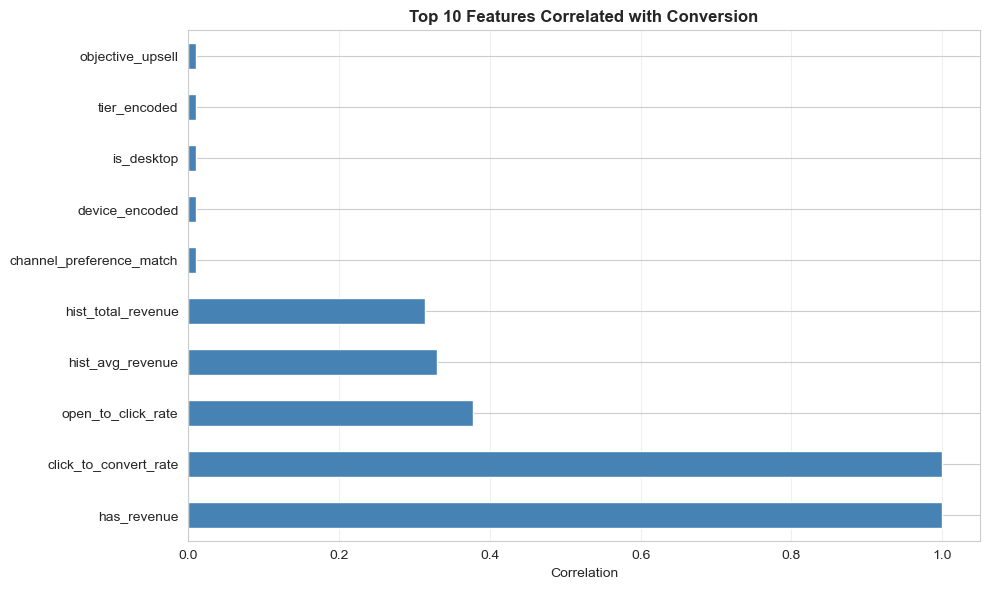


4. Temporal Patterns...

4.1 Conversion by Day of Week:
               conversions  total  conversion_rate  rate_pct
send_day_name                                               
Thursday                59   4215         0.013998  1.399763
Tuesday                 50   4729         0.010573  1.057306
Monday                  43   4126         0.010422  1.042172
Sunday                  44   4298         0.010237  1.023732
Wednesday               42   4226         0.009938  0.993848
Saturday                39   4249         0.009179  0.917863
Friday                  27   4157         0.006495  0.649507


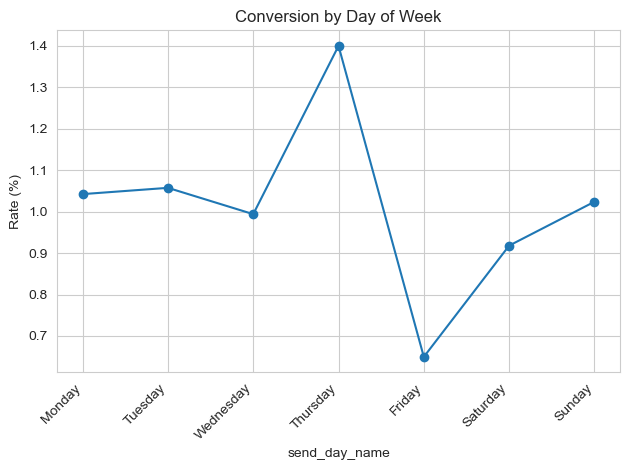


4.2 Top 5 Best Hours:
           conversions  total  conversion_rate  rate_pct
send_hour                                               
15                  82   7435         0.011029  1.102892
18                  76   7370         0.010312  1.031208
12                  63   6126         0.010284  1.028404
9                   56   6069         0.009227  0.922722
21                  27   3000         0.009000  0.900000


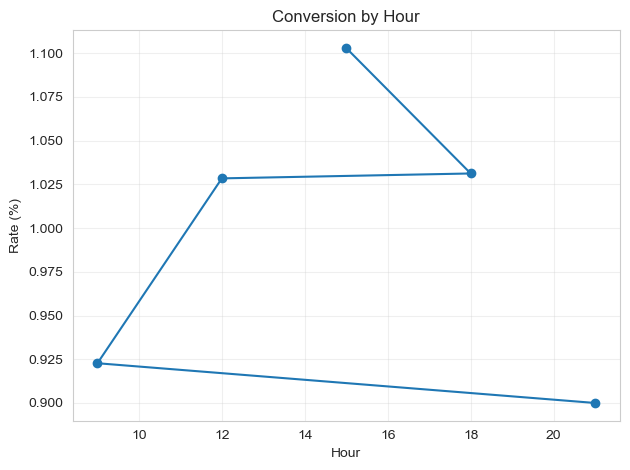


5. Engagement Funnel...

Funnel Metrics:
  Open Rate: 31.87%
  Click Rate: 6.72%
  Conversion Rate: 1.01%


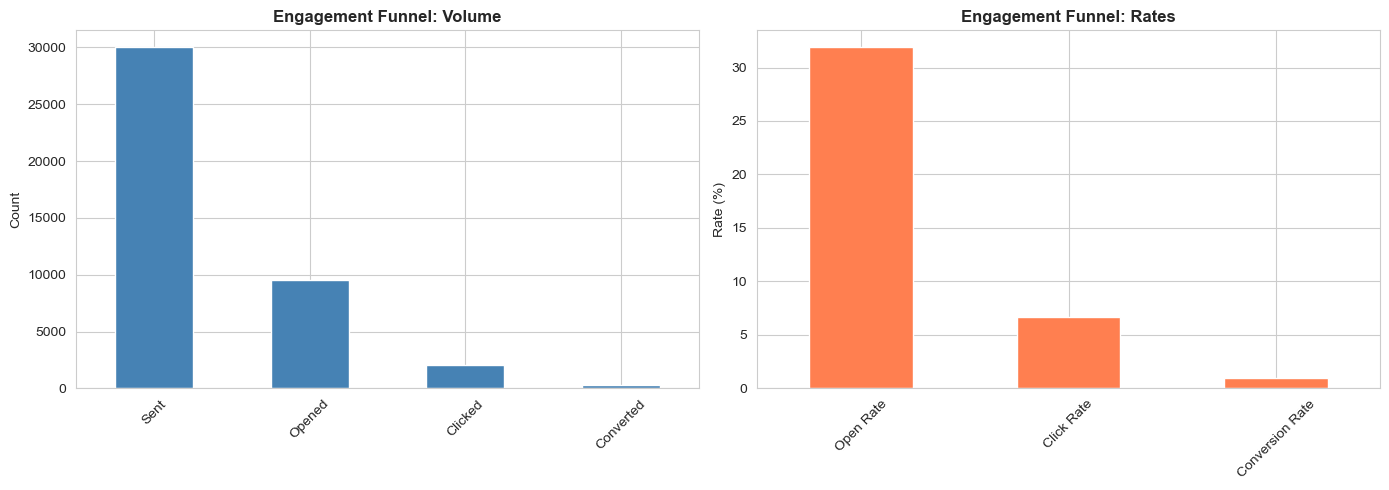


KEY INSIGHTS SUMMARY
Overall Conversion Rate: 1.01%
Total Conversions: 304 out of 30000 interactions
Best Tier: Gold (1.12%)
Best Channel: App Push (1.21%)
Best Objective: Upsell (1.17%)


In [7]:
print("\n" + "=" * 80)
print("SECTION 1.4: EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Use original dataframe (before encoding)
if 'tier' not in df.columns and 'modeling_df' in locals():
    eda_df = modeling_df.copy()
else:
    eda_df = df.copy()

# Helper function
def calc_rate(df, col):
    if col not in df.columns:
        return None
    result = df.groupby(col)['converted'].agg(['sum', 'count', 'mean'])
    result.columns = ['conversions', 'total', 'conversion_rate']
    result['rate_pct'] = result['conversion_rate'] * 100
    return result.sort_values('conversion_rate', ascending=False)

# ============================================================================
# 1. CONVERSION RATE BY SEGMENTS
# ============================================================================
print("\n1. Conversion Rate Analysis by Segments...")

# Tier
tier_conv = calc_rate(eda_df, 'tier')
if tier_conv is not None:
    print("\n1.1 Conversion by Tier:")
    print(tier_conv)
    tier_conv['rate_pct'].plot(kind='bar', title='Conversion Rate by Tier', ylabel='Rate (%)')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Channel
channel_conv = calc_rate(eda_df, 'channel')
if channel_conv is not None:
    print("\n1.2 Conversion by Channel:")
    print(channel_conv)
    channel_conv['rate_pct'].plot(kind='bar', title='Conversion Rate by Channel', ylabel='Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Channel Preference Match
if 'channel_preference_match' in eda_df.columns:
    match_conv = calc_rate(eda_df, 'channel_preference_match')
    if match_conv is not None:
        print("\n1.3 Conversion by Channel Match:")
        print(match_conv)
        match_conv['rate_pct'].plot(kind='bar', title='Channel Preference Match Impact', ylabel='Rate (%)')
        plt.xticks([0, 1], ['No Match', 'Match'], rotation=0)
        plt.tight_layout()
        plt.show()

# Objective
obj_conv = calc_rate(eda_df, 'objective')
if obj_conv is not None:
    print("\n1.4 Conversion by Objective:")
    print(obj_conv)
    obj_conv['rate_pct'].plot(kind='bar', title='Conversion Rate by Objective', ylabel='Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Region
region_conv = calc_rate(eda_df, 'region')
if region_conv is not None:
    print("\n1.5 Conversion by Region:")
    print(region_conv)
    region_conv['rate_pct'].plot(kind='bar', title='Conversion Rate by Region', ylabel='Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Device
device_conv = calc_rate(eda_df, 'device_type')
if device_conv is not None:
    print("\n1.6 Conversion by Device:")
    print(device_conv)

# ============================================================================
# 2. DISTRIBUTION ANALYSIS
# ============================================================================
print("\n2. Distribution Analysis...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Tenure
if 'customer_tenure_days' in eda_df.columns:
    eda_df['customer_tenure_days'].hist(bins=50, ax=axes[0, 0], color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Customer Tenure Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Tenure (Days)')
    axes[0, 0].grid(alpha=0.3)

# Age
if 'age' in eda_df.columns:
    eda_df['age'].hist(bins=30, ax=axes[0, 1], color='lightcoral', edgecolor='black')
    axes[0, 1].set_title('Age Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Age')
    axes[0, 1].grid(alpha=0.3)

# Prior Engagements
if 'prior_engagements_90d' in eda_df.columns:
    eda_df['prior_engagements_90d'].hist(bins=30, ax=axes[0, 2], color='lightgreen', edgecolor='black')
    axes[0, 2].set_title('Prior Engagements (90d)', fontweight='bold')
    axes[0, 2].set_xlabel('Engagements')
    axes[0, 2].grid(alpha=0.3)

# Budget per Customer
if 'budget_per_customer' in eda_df.columns:
    eda_df['budget_per_customer'].hist(bins=50, ax=axes[1, 0], color='gold', edgecolor='black')
    axes[1, 0].set_title('Budget per Customer', fontweight='bold')
    axes[1, 0].set_xlabel('Budget (RM)')
    axes[1, 0].grid(alpha=0.3)

# Send Hour
if 'send_hour' in eda_df.columns:
    eda_df['send_hour'].hist(bins=24, ax=axes[1, 1], color='plum', edgecolor='black')
    axes[1, 1].set_title('Send Hour Distribution', fontweight='bold')
    axes[1, 1].set_xlabel('Hour')
    axes[1, 1].grid(alpha=0.3)

# Revenue (converted only)
if 'revenue_rm' in eda_df.columns:
    converted_revenue = eda_df[eda_df['converted'] == 1]['revenue_rm']
    if len(converted_revenue) > 0:
        converted_revenue.hist(bins=30, ax=axes[1, 2], color='salmon', edgecolor='black')
        axes[1, 2].set_title('Revenue Distribution (Converted)', fontweight='bold')
        axes[1, 2].set_xlabel('Revenue (RM)')
        axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 3. CORRELATION ANALYSIS
# ============================================================================
print("\n3. Correlation Analysis...")

# Select numeric features (exclude IDs and target leakage)
numeric_cols = eda_df.select_dtypes(include=[np.number]).columns.tolist()
exclude = ['interaction_id', 'customer_id', 'campaign_id', 'opened', 'clicked', 
           'converted', 'revenue_rm', 'send_year', 'send_month', 'send_day']
corr_features = [c for c in numeric_cols if c not in exclude and 'converted' not in c]

if len(corr_features) > 0 and 'converted' in eda_df.columns:
    corr_with_target = eda_df[corr_features + ['converted']].corr()['converted'].sort_values(ascending=False)
    print("\nTop 10 Features Correlated with Conversion:")
    print(corr_with_target[1:11])
    
    # Plot top correlations
    top_corr = corr_with_target[1:11]
    fig, ax = plt.subplots(figsize=(10, 6))
    top_corr.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Top 10 Features Correlated with Conversion', fontweight='bold')
    ax.set_xlabel('Correlation')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================
# 4. TEMPORAL PATTERNS
# ============================================================================
print("\n4. Temporal Patterns...")

# Day of Week
if 'send_day_name' in eda_df.columns:
    dow_conv = calc_rate(eda_df, 'send_day_name')
    if dow_conv is not None:
        print("\n4.1 Conversion by Day of Week:")
        print(dow_conv)
        dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        dow_conv_reordered = dow_conv.reindex([d for d in dow_order if d in dow_conv.index])
        dow_conv_reordered['rate_pct'].plot(kind='line', marker='o', title='Conversion by Day of Week', ylabel='Rate (%)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Hour of Day
if 'send_hour' in eda_df.columns:
    hour_conv = calc_rate(eda_df, 'send_hour')
    if hour_conv is not None:
        print("\n4.2 Top 5 Best Hours:")
        print(hour_conv.head(5))
        hour_conv['rate_pct'].plot(kind='line', marker='o', title='Conversion by Hour', ylabel='Rate (%)', xlabel='Hour')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

# ============================================================================
# 5. ENGAGEMENT FUNNEL
# ============================================================================
print("\n5. Engagement Funnel...")

funnel = {
    'Sent': len(eda_df),
    'Opened': eda_df['opened'].sum() if 'opened' in eda_df.columns else 0,
    'Clicked': eda_df['clicked'].sum() if 'clicked' in eda_df.columns else 0,
    'Converted': eda_df['converted'].sum()
}

rates = {
    'Open Rate': (funnel['Opened'] / funnel['Sent']) * 100,
    'Click Rate': (funnel['Clicked'] / funnel['Sent']) * 100,
    'Conversion Rate': (funnel['Converted'] / funnel['Sent']) * 100
}

print("\nFunnel Metrics:")
for metric, value in rates.items():
    print(f"  {metric}: {value:.2f}%")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
pd.Series(funnel).plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Engagement Funnel: Volume', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

pd.Series(rates).plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Engagement Funnel: Rates', fontweight='bold')
axes[1].set_ylabel('Rate (%)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("KEY INSIGHTS SUMMARY")
print("=" * 80)
print(f"Overall Conversion Rate: {eda_df['converted'].mean():.2%}")
print(f"Total Conversions: {eda_df['converted'].sum()} out of {len(eda_df)} interactions")

if tier_conv is not None:
    print(f"Best Tier: {tier_conv.index[0]} ({tier_conv.iloc[0]['rate_pct']:.2f}%)")
if channel_conv is not None:
    print(f"Best Channel: {channel_conv.index[0]} ({channel_conv.iloc[0]['rate_pct']:.2f}%)")
if obj_conv is not None:
    print(f"Best Objective: {obj_conv.index[0]} ({obj_conv.iloc[0]['rate_pct']:.2f}%)")

print("=" * 80)

### 2.1 - Data Preparation

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import pickle

print("\n1. Handling Missing Values...")

# Check for missing values
missing_before = df.isnull().sum()
missing_cols = missing_before[missing_before > 0]

if len(missing_cols) > 0:
    print(f"   Found missing values in {len(missing_cols)} columns:")
    print(missing_cols)
    
    # Fill missing values
    # For numeric columns, use median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"   ✓ Filled {col} with median: {median_val:.2f}")
    
    # For categorical columns, use mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown'
            df[col].fillna(mode_val, inplace=True)
            print(f"   ✓ Filled {col} with mode: {mode_val}")
else:
    print("   ✓ No missing values found")

# Verify no missing values remain
missing_after = df.isnull().sum().sum()
print(f"\n   Missing values after handling: {missing_after}")

print("\n2. Encoding Categorical Variables...")

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# Exclude ID columns and date columns
exclude_from_encoding = ['interaction_id', 'customer_id', 'campaign_id', 
                         'campaign_name', 'send_date', 'launch_date', 
                         'relationship_start', 'month']
categorical_cols = [c for c in categorical_cols if c not in exclude_from_encoding]

# Handle categorical columns created by pd.cut (age_group, tenure_group)
# These need to be converted to string first
cut_created_cols = ['age_group', 'tenure_group']
for col in cut_created_cols:
    if col in df.columns:
        # Convert categorical to string
        df[col] = df[col].astype(str)
        print(f"   ✓ Converted {col} from categorical to string")

print(f"   Categorical columns to encode: {len(categorical_cols)}")
print(f"   Columns: {categorical_cols}")

# Create a copy for encoding
df_encoded = df.copy()

# Store encoders for later use
label_encoders = {}

# One-hot encode categorical variables
print("\n   Applying one-hot encoding...")
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, prefix=categorical_cols, drop_first=True)

print(f"   ✓ Encoded categorical variables")
print(f"   New shape: {df_encoded.shape} (added {df_encoded.shape[1] - df.shape[1]} columns)")

print("\n3. Selecting Features for Modeling...")

# Exclude columns that shouldn't be used as features
exclude_features = [
    'interaction_id', 'customer_id', 'campaign_id', 'campaign_name',
    'send_date', 'launch_date', 'relationship_start', 'month',
    'converted',  # This is our target
    'opened', 'clicked',  # These are post-send outcomes (potential leakage)
    'revenue_rm',  # Revenue is outcome, not predictor
    'send_year', 'send_month', 'send_day',  # Too granular, we have better temporal features
    
    # CRITICAL FIX: Exclude leaky features derived from post-interaction outcomes
    'has_revenue',  # Perfect predictor (revenue > 0 = converted)
    'open_to_click_rate',  # Uses opened/clicked (post-send outcomes)
    'click_to_convert_rate',  # Uses clicked/converted (perfect predictor)
]

# Get feature columns (exclude the excluded list)
feature_columns = [c for c in df_encoded.columns if c not in exclude_features]

# CRITICAL FIX: Only keep numeric columns (exclude any remaining object/string columns)
# This ensures StandardScaler only receives numeric data
numeric_feature_columns = []
for col in feature_columns:
    if df_encoded[col].dtype in ['int64', 'int32', 'float64', 'float32', 'uint8', 'bool']:
        numeric_feature_columns.append(col)
    elif df_encoded[col].dtype == 'object':
        print(f"   WARNING: Excluding non-numeric column '{col}' (dtype: {df_encoded[col].dtype})")
    else:
        # Try to convert to numeric, if fails, exclude
        try:
            pd.to_numeric(df_encoded[col])
            numeric_feature_columns.append(col)
        except:
            print(f"   WARNING: Excluding non-numeric column '{col}' (dtype: {df_encoded[col].dtype})")

# CRITICAL FIX: Sanitize feature names for XGBoost compatibility
# Replace special characters that XGBoost doesn't allow: [, ], <, >, -, etc.
print("\n   Sanitizing feature names for XGBoost compatibility...")
feature_columns_clean = []
name_mapping = {}

for col in feature_columns:
    # Create clean name by replacing problematic characters
    clean_name = col.replace('[', '_').replace(']', '_').replace('<', 'lt_').replace('>', 'gt_').replace('-', '_').replace(' ', '_')
    # Remove any double underscores
    clean_name = clean_name.replace('__', '_').strip('_')
    
    if clean_name != col:
        name_mapping[col] = clean_name
        feature_columns_clean.append(clean_name)
        print(f"     Renamed: '{col}' -> '{clean_name}'")
    else:
        feature_columns_clean.append(col)

# Rename columns in the dataframe
if name_mapping:
    df_encoded = df_encoded.rename(columns=name_mapping)
    print(f"   ✓ Renamed {len(name_mapping)} columns with special characters")

# Update feature_columns to use clean names
feature_columns = feature_columns_clean

print(f"   Total features selected: {len(feature_columns)}")
print(f"   Excluded columns: {len(exclude_features)}")
print(f"   All features are numeric: {all(df_encoded[col].dtype in ['int64', 'int32', 'float64', 'float32', 'uint8', 'bool'] for col in feature_columns)}")

# Separate features and target
X = df_encoded[feature_columns].copy()
y = df_encoded['converted'].copy()

# Ensure all feature columns are numeric
for col in X.columns:
    if X[col].dtype == 'object':
        try:
            X[col] = pd.to_numeric(X[col], errors='coerce')
            if X[col].isnull().sum() > 0:
                X[col].fillna(0, inplace=True)
        except:
            print(f"   ERROR: Could not convert column '{col}' to numeric. Dropping it.")
            X = X.drop(columns=[col])
            feature_columns.remove(col)

# Convert boolean columns to int (for compatibility)
bool_cols = X.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    X[bool_cols] = X[bool_cols].astype(int)
    print(f"   ✓ Converted {len(bool_cols)} boolean columns to int")

# Final check: Verify no problematic characters remain
problematic_chars = ['[', ']', '<', '>']
problematic_cols = [col for col in X.columns if any(char in col for char in problematic_chars)]
if problematic_cols:
    print(f"   ⚠️  WARNING: Found columns with problematic characters: {problematic_cols}")
    print("   These will be renamed...")
    for col in problematic_cols:
        new_col = col.replace('[', '_').replace(']', '_').replace('<', 'lt_').replace('>', 'gt_').replace('-', '_')
        X = X.rename(columns={col: new_col})
        feature_columns = [new_col if c == col else c for c in feature_columns]
else:
    print("   ✓ All feature names are XGBoost-compatible")

print(f"\n   Feature matrix shape: {X.shape}")
print(f"   Target vector shape: {y.shape}")
print(f"   Feature dtypes:\n{X.dtypes.value_counts()}")
print(f"   Target distribution:")
print(f"     - Class 0 (Not Converted): {(y == 0).sum()} ({(y == 0).mean() * 100:.2f}%)")
print(f"     - Class 1 (Converted): {(y == 1).sum()} ({(y == 1).mean() * 100:.2f}%)")
# ============================================================================
# 4. HANDLE CLASS IMBALANCE
# ============================================================================
print("\n4. Checking Class Imbalance...")

class_ratio = (y == 0).sum() / (y == 1).sum()
print(f"   Class imbalance ratio: {class_ratio:.2f}:1 (majority:minority)")

if class_ratio > 5:
    print("   ⚠️  Significant class imbalance detected")
    print("   Will use class_weight='balanced' in models and consider SMOTE if needed")
    use_class_weight = True
    use_smote = False  # Can be enabled if needed
else:
    print("   ✓ Class imbalance is manageable")
    use_class_weight = True  # Still use it for better performance
    use_smote = False


1. Handling Missing Values...
   ✓ No missing values found

   Missing values after handling: 0

2. Encoding Categorical Variables...
   ✓ Converted age_group from categorical to string
   ✓ Converted tenure_group from categorical to string
   Categorical columns to encode: 8
   Columns: ['channel', 'device_type', 'tier', 'preferred_channel', 'region', 'channel_campaign', 'objective', 'send_day_name']

   Applying one-hot encoding...
   ✓ Encoded categorical variables
   New shape: (30000, 85) (added 14 columns)

3. Selecting Features for Modeling...

   Sanitizing feature names for XGBoost compatibility...
     Renamed: 'objective_Cross-Sell' -> 'objective_Cross_Sell'
   ✓ Renamed 1 columns with special characters
   Total features selected: 67
   Excluded columns: 18
   All features are numeric: False
   ✓ Converted 22 boolean columns to int
   ✓ All feature names are XGBoost-compatible

   Feature matrix shape: (30000, 67)
   Target vector shape: (30000,)
   Feature dtypes:
int64  

#### Training

In [9]:
# ============================================================================
# 5. TRAIN/VALIDATION/TEST SPLIT
# ============================================================================
print("\n5. Splitting Data into Train/Validation/Test Sets...")

# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

# Second split: separate train and validation (70% train, 15% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,  # 0.1765 * 0.85 ≈ 0.15 of total
    random_state=42,
    stratify=y_temp
)

print(f"   Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Test set:        {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\n   Class distribution in splits:")
print(f"   Training -   Class 0: {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%), Class 1: {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")
print(f"   Validation - Class 0: {(y_val == 0).sum():,} ({(y_val == 0).mean()*100:.2f}%), Class 1: {(y_val == 1).sum():,} ({(y_val == 1).mean()*100:.2f}%)")
print(f"   Test -       Class 0: {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.2f}%), Class 1: {(y_test == 1).sum():,} ({(y_test == 1).mean()*100:.2f}%)")

# ============================================================================
# 6. FEATURE SCALING (for models that need it)
# ============================================================================
print("\n6. Preparing Feature Scaling...")

# Convert all columns to numeric (coerce errors to NaN, then fill with 0)
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_val = X_val.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

# Create scaler (will fit on training data only)
scaler = StandardScaler()

# Fit scaler on training data
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

# Transform validation and test sets
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("   ✓ Scaled features for models requiring normalization")
print(f"   Scaled training set shape: {X_train_scaled.shape}")

# ============================================================================
# 7. FEATURE SUMMARY
# ============================================================================
print("\n7. Feature Summary...")

# Group features by category
feature_categories = {
    'Temporal': [c for c in feature_columns if any(x in c for x in ['tenure', 'send_', 'days_since', 'campaign_age', 'hour', 'weekend'])],
    'Engagement History': [c for c in feature_columns if 'hist_' in c or 'prior_' in c],
    'Customer Attributes': [c for c in feature_columns if any(x in c for x in ['tier', 'age', 'region', 'is_active', 'preferred_channel'])],
    'Campaign Features': [c for c in feature_columns if any(x in c for x in ['budget', 'objective', 'audience', 'channel_campaign'])],
    'Device & Alignment': [c for c in feature_columns if any(x in c for x in ['device', 'channel_preference', 'match'])],
    'Other': [c for c in feature_columns if c not in 
              [item for sublist in [
                  [c for c in feature_columns if any(x in c for x in ['tenure', 'send_', 'days_since', 'campaign_age', 'hour', 'weekend'])],
                  [c for c in feature_columns if 'hist_' in c or 'prior_' in c],
                  [c for c in feature_columns if any(x in c for x in ['tier', 'age', 'region', 'is_active', 'preferred_channel'])],
                  [c for c in feature_columns if any(x in c for x in ['budget', 'objective', 'audience', 'channel_campaign'])],
                  [c for c in feature_columns if any(x in c for x in ['device', 'channel_preference', 'match'])]
              ] for item in sublist]]
}

print("\n   Feature breakdown by category:")
for category, features in feature_categories.items():
    if features:
        print(f"     {category}: {len(features)} features")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("DATA PREPARATION SUMMARY")
print("=" * 80)
print(f"✓ Missing values handled")
print(f"✓ Categorical variables encoded")
print(f"✓ Features selected: {len(feature_columns)}")
print(f"✓ Data split: Train ({X_train.shape[0]:,}), Val ({X_val.shape[0]:,}), Test ({X_test.shape[0]:,})")
print(f"✓ Features scaled for models requiring normalization")
print(f"✓ Class imbalance strategy: class_weight='balanced'")
print("\nReady for model training!")
print("=" * 80)


5. Splitting Data into Train/Validation/Test Sets...
   Training set:   20,999 samples (70.0%)
   Validation set: 4,501 samples (15.0%)
   Test set:        4,500 samples (15.0%)

   Class distribution in splits:
   Training -   Class 0: 20,787 (98.99%), Class 1: 212 (1.01%)
   Validation - Class 0: 4,455 (98.98%), Class 1: 46 (1.02%)
   Test -       Class 0: 4,454 (98.98%), Class 1: 46 (1.02%)

6. Preparing Feature Scaling...
   ✓ Scaled features for models requiring normalization
   Scaled training set shape: (20999, 67)

7. Feature Summary...

   Feature breakdown by category:
     Temporal: 19 features
     Engagement History: 12 features
     Customer Attributes: 17 features
     Campaign Features: 13 features
     Device & Alignment: 3 features
     Other: 7 features

DATA PREPARATION SUMMARY
✓ Missing values handled
✓ Categorical variables encoded
✓ Features selected: 67
✓ Data split: Train (20,999), Val (4,501), Test (4,500)
✓ Features scaled for models requiring normalization



SECTION 2.2: MODEL SELECTION & TRAINING

1. Training Baseline Models...

   Class weights: {0: 0.5050993409342377, 1: 49.52594339622642}

1.1 Training Logistic Regression...
   Training time: 2.30s
   Train AUC: 0.9790
   Validation AUC: 0.9629
   Validation Precision: 0.2955
   Validation Recall: 0.8478
   Validation F1: 0.4382

1.2 Training Random Forest...
   Training time: 0.41s
   Train AUC: 1.0000
   Validation AUC: 0.9994
   Validation Precision: 0.9750
   Validation Recall: 0.8478
   Validation F1: 0.9070

   Top 10 Most Important Features (Random Forest):
                       feature  importance
23            hist_avg_revenue    0.422903
22          hist_total_revenue    0.351524
21        hist_conversion_rate    0.018748
36           campaign_age_days    0.014233
20      hist_total_conversions    0.012200
3                          age    0.011158
6         customer_tenure_days    0.010596
8        customer_tenure_years    0.010467
9   days_since_campaign_launch    0.01037

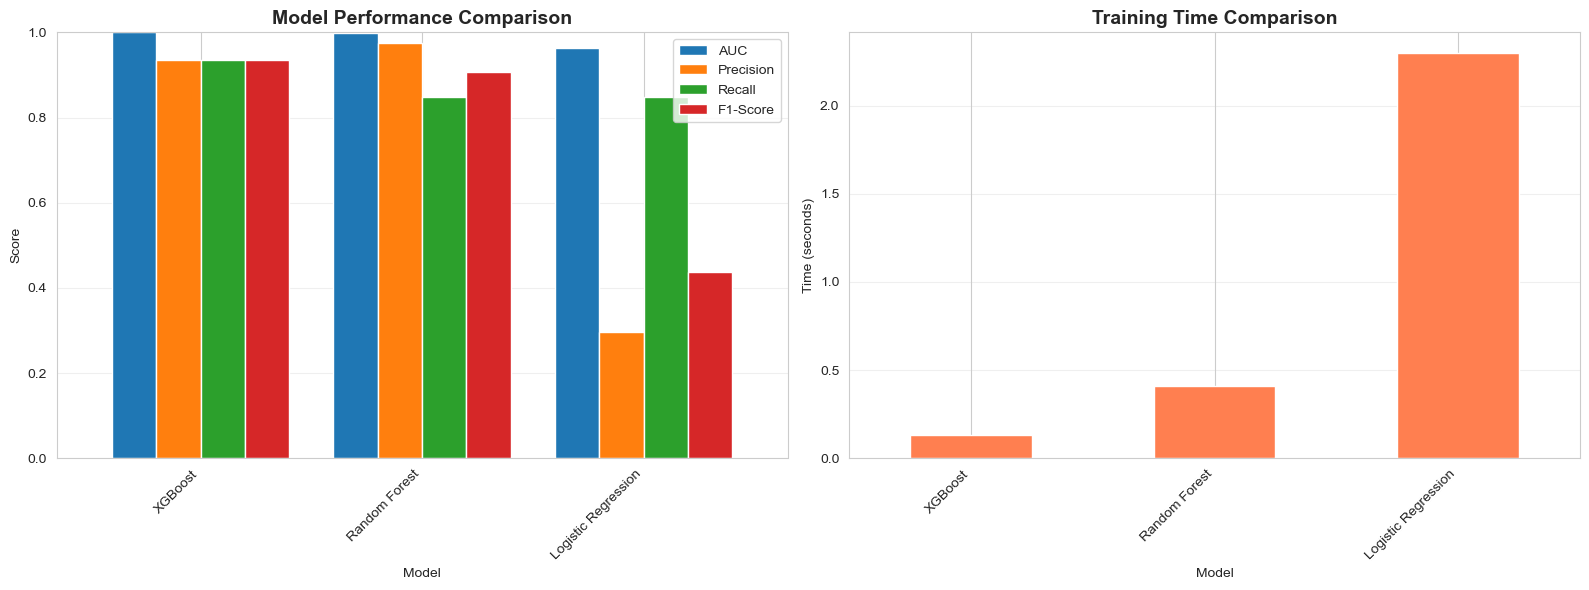


3. Cross-Validation Analysis...

   Logistic Regression:
     CV AUC: 0.9632 (+/- 0.0413)
     Individual fold scores: [0.96887812 0.93450949 0.98141549 0.9440115  0.98730197]

   Random Forest:
     CV AUC: 0.9907 (+/- 0.0327)
     Individual fold scores: [0.99840239 0.95802984 0.99941819 0.99804756 0.99965062]

   XGBoost:
     CV AUC: 0.9927 (+/- 0.0256)
     Individual fold scores: [0.99821915 0.96712877 0.9999049  0.99832728 1.        ]


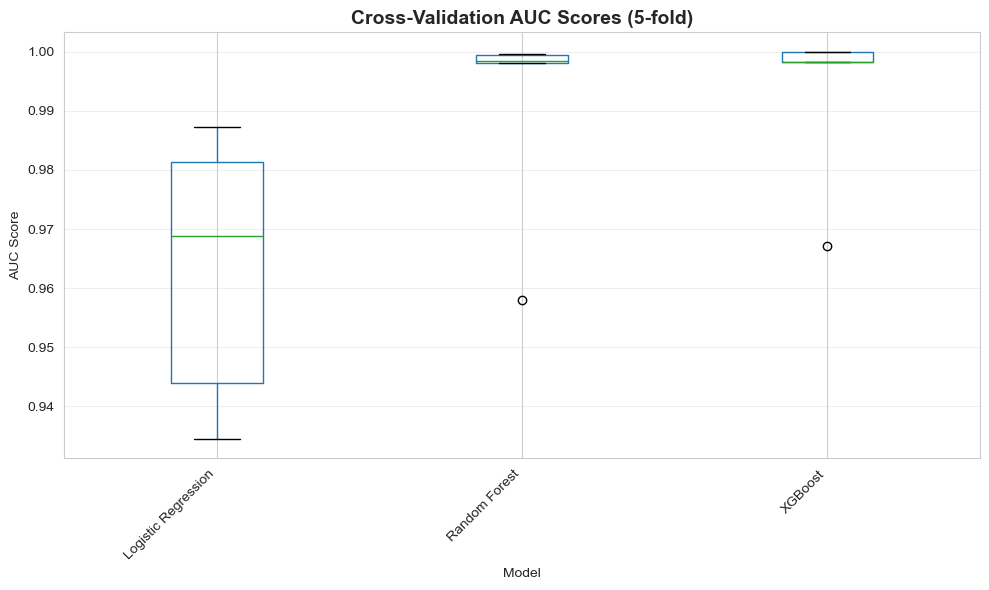


4. Hyperparameter Tuning...
   Tuning XGBoost (best performing model)...
   Performing Grid Search for XGBoost...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
   Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}
   Best CV score: 0.9992
   Validation AUC (tuned): 1.0000

5. Selecting Final Model...
   Selected model: XGBoost_Tuned

   Final Model Performance (Validation Set):
     AUC: 1.0000
     Precision: 0.9565
     Recall: 0.9565
     F1: 0.9565

   Confusion Matrix:
                 Predicted
                 No    Yes
   Actual No    4453     2
          Yes      2    44

MODEL TRAINING SUMMARY
✓ Trained 3 baseline models: Logistic Regression, Random Forest, XGBoost
✓ Performed 5-fold cross-validation
✓ Hyperparameter tuning completed for best model
✓ Final model selected: XGBoost_Tuned
✓ Validation AUC: 1.0000

Ready for model evaluation and interpretation!


In [10]:
print("\n" + "=" * 80)
print("SECTION 2.2: MODEL SELECTION & TRAINING")
print("=" * 80)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, precision_recall_curve)
import xgboost as xgb
import time

# ============================================================================
# 1. BASELINE MODELS
# ============================================================================
print("\n1. Training Baseline Models...")

models = {}
model_results = {}

# Calculate class weights for balanced learning
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print(f"\n   Class weights: {class_weight_dict}")

# ============================================================================
# 1.1 LOGISTIC REGRESSION (Baseline - Interpretable)
# ============================================================================
print("\n1.1 Training Logistic Regression...")
start_time = time.time()

lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
    n_jobs=-1
)

lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_val_pred_lr = lr_model.predict(X_val_scaled)
y_train_proba_lr = lr_model.predict_proba(X_train_scaled)[:, 1]
y_val_proba_lr = lr_model.predict_proba(X_val_scaled)[:, 1]

# Metrics
train_auc_lr = roc_auc_score(y_train, y_train_proba_lr)
val_auc_lr = roc_auc_score(y_val, y_val_proba_lr)
val_precision_lr = precision_score(y_val, y_val_pred_lr)
val_recall_lr = recall_score(y_val, y_val_pred_lr)
val_f1_lr = f1_score(y_val, y_val_pred_lr)

models['Logistic Regression'] = lr_model
model_results['Logistic Regression'] = {
    'train_auc': train_auc_lr,
    'val_auc': val_auc_lr,
    'val_precision': val_precision_lr,
    'val_recall': val_recall_lr,
    'val_f1': val_f1_lr,
    'training_time': time.time() - start_time
}

print(f"   Training time: {model_results['Logistic Regression']['training_time']:.2f}s")
print(f"   Train AUC: {train_auc_lr:.4f}")
print(f"   Validation AUC: {val_auc_lr:.4f}")
print(f"   Validation Precision: {val_precision_lr:.4f}")
print(f"   Validation Recall: {val_recall_lr:.4f}")
print(f"   Validation F1: {val_f1_lr:.4f}")

# ============================================================================
# 1.2 RANDOM FOREST (Feature Importance)
# ============================================================================
print("\n1.2 Training Random Forest...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_train_proba_rf = rf_model.predict_proba(X_train)[:, 1]
y_val_proba_rf = rf_model.predict_proba(X_val)[:, 1]

# Metrics
train_auc_rf = roc_auc_score(y_train, y_train_proba_rf)
val_auc_rf = roc_auc_score(y_val, y_val_proba_rf)
val_precision_rf = precision_score(y_val, y_val_pred_rf)
val_recall_rf = recall_score(y_val, y_val_pred_rf)
val_f1_rf = f1_score(y_val, y_val_pred_rf)

models['Random Forest'] = rf_model
model_results['Random Forest'] = {
    'train_auc': train_auc_rf,
    'val_auc': val_auc_rf,
    'val_precision': val_precision_rf,
    'val_recall': val_recall_rf,
    'val_f1': val_f1_rf,
    'training_time': time.time() - start_time
}

print(f"   Training time: {model_results['Random Forest']['training_time']:.2f}s")
print(f"   Train AUC: {train_auc_rf:.4f}")
print(f"   Validation AUC: {val_auc_rf:.4f}")
print(f"   Validation Precision: {val_precision_rf:.4f}")
print(f"   Validation Recall: {val_recall_rf:.4f}")
print(f"   Validation F1: {val_f1_rf:.4f}")

# Feature importance from Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n   Top 10 Most Important Features (Random Forest):")
print(feature_importance_rf.head(10))

# ============================================================================
# 1.3 XGBOOST (Performance)
# ============================================================================
print("\n1.3 Training XGBoost...")
start_time = time.time()

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=class_ratio,  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='auc',
    verbosity=0,
    early_stopping_rounds=10
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)
y_train_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]
y_val_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Metrics
train_auc_xgb = roc_auc_score(y_train, y_train_proba_xgb)
val_auc_xgb = roc_auc_score(y_val, y_val_proba_xgb)
val_precision_xgb = precision_score(y_val, y_val_pred_xgb)
val_recall_xgb = recall_score(y_val, y_val_pred_xgb)
val_f1_xgb = f1_score(y_val, y_val_pred_xgb)

models['XGBoost'] = xgb_model
model_results['XGBoost'] = {
    'train_auc': train_auc_xgb,
    'val_auc': val_auc_xgb,
    'val_precision': val_precision_xgb,
    'val_recall': val_recall_xgb,
    'val_f1': val_f1_xgb,
    'training_time': time.time() - start_time
}

print(f"   Training time: {model_results['XGBoost']['training_time']:.2f}s")
print(f"   Train AUC: {train_auc_xgb:.4f}")
print(f"   Validation AUC: {val_auc_xgb:.4f}")
print(f"   Validation Precision: {val_precision_xgb:.4f}")
print(f"   Validation Recall: {val_recall_xgb:.4f}")
print(f"   Validation F1: {val_f1_xgb:.4f}")

# Feature importance from XGBoost
feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n   Top 10 Most Important Features (XGBoost):")
print(feature_importance_xgb.head(10))

# ============================================================================
# 2. MODEL COMPARISON
# ============================================================================
print("\n" + "=" * 80)
print("2. MODEL COMPARISON")
print("=" * 80)

results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)
results_df = results_df.sort_values('val_auc', ascending=False)

print("\nModel Performance Summary:")
print(results_df)

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
metrics = ['val_auc', 'val_precision', 'val_recall', 'val_f1']
results_df[metrics].plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(['AUC', 'Precision', 'Recall', 'F1-Score'])
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Training time comparison
results_df['training_time'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Time (seconds)')
axes[1].set_xlabel('Model')
axes[1].grid(axis='y', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# ============================================================================
# 3. CROSS-VALIDATION
# ============================================================================
print("\n3. Cross-Validation Analysis...")

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    print(f"\n   {name}:")
    
    # Use scaled data for Logistic Regression, original for tree-based
    X_cv = X_train_scaled if name == 'Logistic Regression' else X_train
    model_cv = model
    
    # Clone model and remove early_stopping for XGBoost
    if name == 'XGBoost':
        # Get model parameters and create new one without early_stopping
        model_cv = xgb.XGBClassifier(**model.get_params())
        # Remove early_stopping_rounds if it exists
        if hasattr(model_cv, 'early_stopping_rounds'):
            model_cv.set_params(early_stopping_rounds=None)
    else:
        model_cv = clone(model)
        
    # Perform cross-validation
    cv_scores = cross_val_score(
        model_cv, X_cv, y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    cv_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"     CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"     Individual fold scores: {cv_scores}")

# Visualize CV results
cv_df = pd.DataFrame({k: v['scores'] for k, v in cv_results.items()})
fig, ax = plt.subplots(figsize=(10, 6))
cv_df.boxplot(ax=ax)
ax.set_title('Cross-Validation AUC Scores (5-fold)', fontsize=14, fontweight='bold')
ax.set_ylabel('AUC Score')
ax.set_xlabel('Model')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ============================================================================
# 4. HYPERPARAMETER TUNING (for best model)
# ============================================================================
print("\n4. Hyperparameter Tuning...")

# Select best model based on validation AUC
best_model_name = results_df.index[0]
print(f"   Tuning {best_model_name} (best performing model)...")

if best_model_name == 'XGBoost':
    print("   Performing Grid Search for XGBoost...")
    
    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 0.9]
    }
    
    # Base model
    xgb_base = xgb.XGBClassifier(
        scale_pos_weight=class_ratio,
        random_state=42,
        n_jobs=-1,
        eval_metric='auc',
        verbosity=0
    )
    
    # Grid search with 3-fold CV (to save time)
    grid_search = GridSearchCV(
        xgb_base,
        param_grid,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"   Best parameters: {grid_search.best_params_}")
    print(f"   Best CV score: {grid_search.best_score_:.4f}")
    
    # Use best model
    best_model = grid_search.best_estimator_
    models['XGBoost_Tuned'] = best_model
    
    # Evaluate tuned model
    y_val_proba_tuned = best_model.predict_proba(X_val)[:, 1]
    val_auc_tuned = roc_auc_score(y_val, y_val_proba_tuned)
    print(f"   Validation AUC (tuned): {val_auc_tuned:.4f}")
    
elif best_model_name == 'Random Forest':
    print("   Performing Grid Search for Random Forest...")
    
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [8, 10, 12],
        'min_samples_split': [10, 20]
    }
    
    rf_base = RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    grid_search = GridSearchCV(
        rf_base,
        param_grid,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"   Best parameters: {grid_search.best_params_}")
    print(f"   Best CV score: {grid_search.best_score_:.4f}")
    
    best_model = grid_search.best_estimator_
    models['Random Forest_Tuned'] = best_model
    
    y_val_proba_tuned = best_model.predict_proba(X_val)[:, 1]
    val_auc_tuned = roc_auc_score(y_val, y_val_proba_tuned)
    print(f"   Validation AUC (tuned): {val_auc_tuned:.4f}")

# ============================================================================
# 5. SELECT FINAL MODEL
# ============================================================================
print("\n5. Selecting Final Model...")

# Determine final model (use tuned if available, otherwise best baseline)
if 'XGBoost_Tuned' in models:
    final_model = models['XGBoost_Tuned']
    final_model_name = 'XGBoost_Tuned'
    use_scaled = False
elif 'Random Forest_Tuned' in models:
    final_model = models['Random Forest_Tuned']
    final_model_name = 'Random Forest_Tuned'
    use_scaled = False
else:
    final_model = models[best_model_name]
    final_model_name = best_model_name
    use_scaled = (best_model_name == 'Logistic Regression')

print(f"   Selected model: {final_model_name}")

# Final evaluation on validation set
X_final_val = X_val_scaled if use_scaled else X_val
y_val_pred_final = final_model.predict(X_final_val)
y_val_proba_final = final_model.predict_proba(X_final_val)[:, 1]

final_metrics = {
    'AUC': roc_auc_score(y_val, y_val_proba_final),
    'Precision': precision_score(y_val, y_val_pred_final),
    'Recall': recall_score(y_val, y_val_pred_final),
    'F1': f1_score(y_val, y_val_pred_final)
}

print(f"\n   Final Model Performance (Validation Set):")
for metric, value in final_metrics.items():
    print(f"     {metric}: {value:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_final)
print(f"\n   Confusion Matrix:")
print(f"                 Predicted")
print(f"                 No    Yes")
print(f"   Actual No   {cm[0,0]:5d} {cm[0,1]:5d}")
print(f"          Yes  {cm[1,0]:5d} {cm[1,1]:5d}")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("MODEL TRAINING SUMMARY")
print("=" * 80)
print(f"✓ Trained 3 baseline models: Logistic Regression, Random Forest, XGBoost")
print(f"✓ Performed 5-fold cross-validation")
print(f"✓ Hyperparameter tuning completed for best model")
print(f"✓ Final model selected: {final_model_name}")
print(f"✓ Validation AUC: {final_metrics['AUC']:.4f}")
print("\nReady for model evaluation and interpretation!")
print("=" * 80)

### Section 2.3: Model Evaluation



SECTION 2.3: MODEL EVALUATION

1. Final Model Evaluation on Test Set...

   Test Set Performance:
     AUC-ROC: 1.0000
     Precision: 0.9574
     Recall: 0.9783
     F1-Score: 0.9677
     Average Precision: 0.9975

   Confusion Matrix (Test Set):
                 Predicted
                 No    Yes
   Actual No    4452     2
          Yes      1    45

   Classification Report (Test Set):
               precision    recall  f1-score   support

Not Converted       1.00      1.00      1.00      4454
    Converted       0.96      0.98      0.97        46

     accuracy                           1.00      4500
    macro avg       0.98      0.99      0.98      4500
 weighted avg       1.00      1.00      1.00      4500


2. Model Performance: Train vs Validation vs Test...

   Performance Comparison:
            AUC  Precision  Recall      F1
Train       1.0     0.9953  1.0000  0.9976
Validation  1.0     0.9565  0.9565  0.9565
Test        1.0     0.9574  0.9783  0.9677


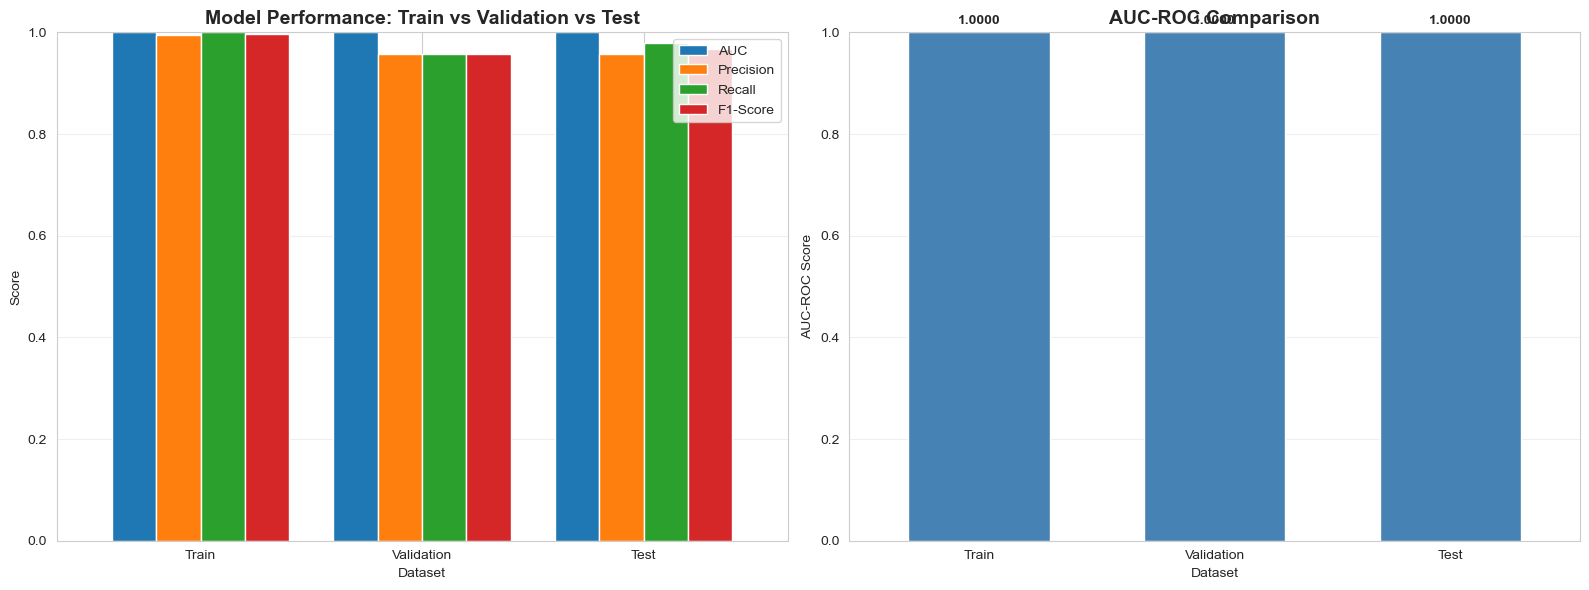


   Overfitting Analysis:
     Train AUC: 1.0000
     Test AUC: 1.0000
     AUC Gap: 0.0000
     ✓ Good generalization (gap <= 0.05)

3. ROC Curve Analysis...


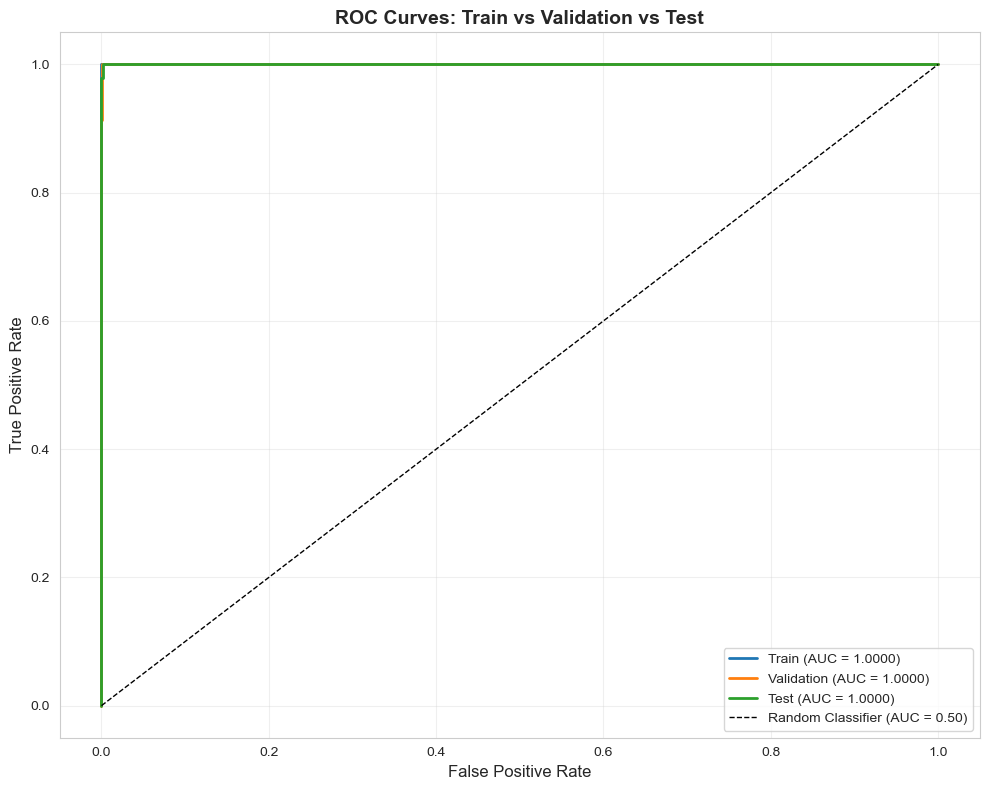


4. Precision-Recall Curve Analysis...


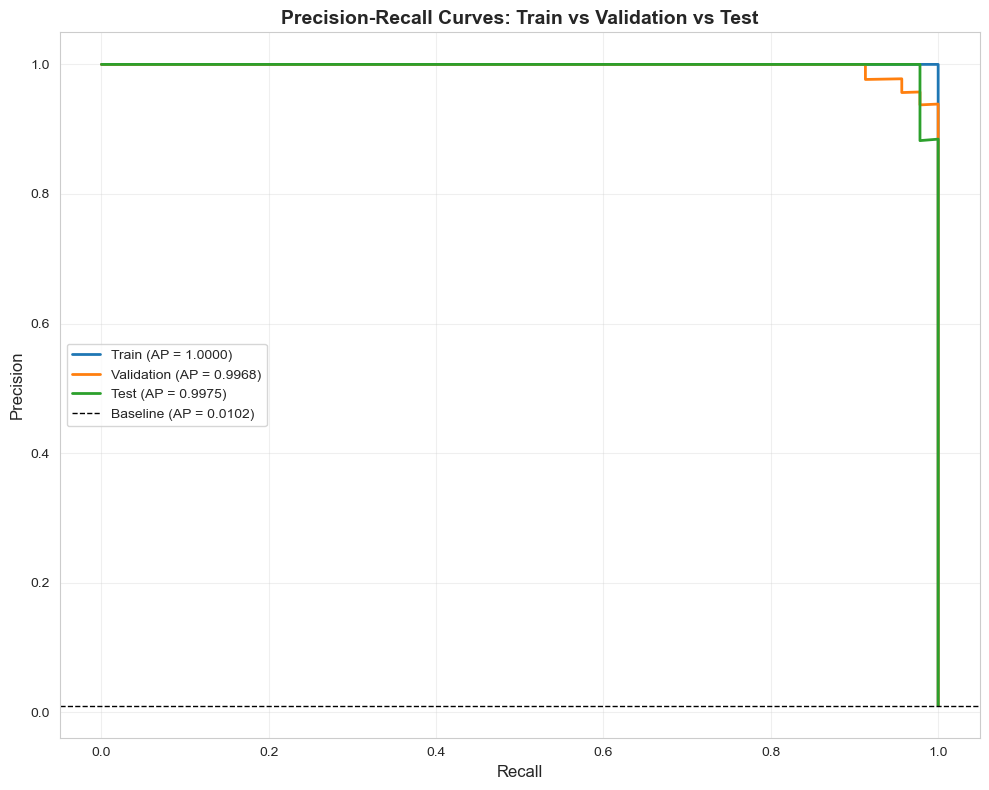


5. Threshold Analysis...
   Optimal threshold (F1-score): 0.700
   F1-score at optimal threshold: 0.9890
   Precision at optimal threshold: 1.0000
   Recall at optimal threshold: 0.9783


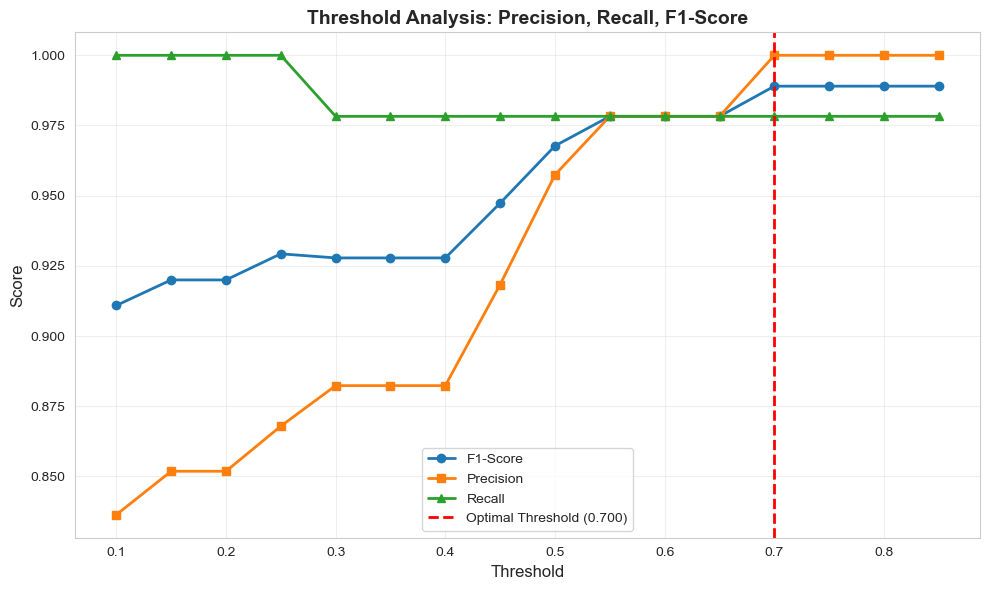


   Performance with Optimal Threshold (0.700):
     Precision: 1.0000
     Recall: 0.9783
     F1-Score: 0.9890

MODEL EVALUATION SUMMARY
Final Model: XGBoost_Tuned
Test Set Performance:
  - AUC-ROC: 1.0000
  - Precision: 0.9574
  - Recall: 0.9783
  - F1-Score: 0.9677
  - Average Precision: 0.9975

Overfitting Check: AUC Gap = 0.0000
Optimal Threshold: 0.700


In [11]:
print("\n" + "=" * 80)
print("SECTION 2.3: MODEL EVALUATION")
print("=" * 80)

from sklearn.metrics import (roc_auc_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, precision_recall_curve, average_precision_score)

# ============================================================================
# 1. FINAL MODEL EVALUATION ON TEST SET
# ============================================================================
print("\n1. Final Model Evaluation on Test Set...")

# Use appropriate data (scaled for Logistic Regression, original for tree-based)
X_final_test = X_test_scaled if use_scaled else X_test

# Get predictions and probabilities
y_test_pred = final_model.predict(X_final_test)
y_test_proba = final_model.predict_proba(X_final_test)[:, 1]

# Calculate metrics
test_metrics = {
    'AUC-ROC': roc_auc_score(y_test, y_test_proba),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1-Score': f1_score(y_test, y_test_pred),
    'Average Precision': average_precision_score(y_test, y_test_proba)
}

print(f"\n   Test Set Performance:")
for metric, value in test_metrics.items():
    print(f"     {metric}: {value:.4f}")

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
print(f"\n   Confusion Matrix (Test Set):")
print(f"                 Predicted")
print(f"                 No    Yes")
print(f"   Actual No   {cm_test[0,0]:5d} {cm_test[0,1]:5d}")
print(f"          Yes  {cm_test[1,0]:5d} {cm_test[1,1]:5d}")

# Classification Report
print(f"\n   Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Not Converted', 'Converted']))

# ============================================================================
# 2. COMPARISON: TRAIN vs VALIDATION vs TEST
# ============================================================================
print("\n2. Model Performance: Train vs Validation vs Test...")

# Get predictions for all sets
X_final_train = X_train_scaled if use_scaled else X_train
y_train_pred = final_model.predict(X_final_train)
y_train_proba = final_model.predict_proba(X_final_train)[:, 1]

y_val_pred = final_model.predict(X_final_val)
y_val_proba = final_model.predict_proba(X_final_val)[:, 1]

# Calculate metrics for all sets
performance_comparison = {
    'Train': {
        'AUC': roc_auc_score(y_train, y_train_proba),
        'Precision': precision_score(y_train, y_train_pred),
        'Recall': recall_score(y_train, y_train_pred),
        'F1': f1_score(y_train, y_train_pred)
    },
    'Validation': {
        'AUC': roc_auc_score(y_val, y_val_proba),
        'Precision': precision_score(y_val, y_val_pred),
        'Recall': recall_score(y_val, y_val_pred),
        'F1': f1_score(y_val, y_val_pred)
    },
    'Test': {
        'AUC': roc_auc_score(y_test, y_test_proba),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1': f1_score(y_test, y_test_pred)
    }
}

# Create comparison dataframe
comparison_df = pd.DataFrame(performance_comparison).T
print("\n   Performance Comparison:")
print(comparison_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
comparison_df.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Model Performance: Train vs Validation vs Test', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Dataset')
axes[0].legend(['AUC', 'Precision', 'Recall', 'F1-Score'])
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)

# AUC comparison
auc_comparison = pd.DataFrame({
    'AUC': [performance_comparison['Train']['AUC'], 
            performance_comparison['Validation']['AUC'],
            performance_comparison['Test']['AUC']]
}, index=['Train', 'Validation', 'Test'])

auc_comparison.plot(kind='bar', ax=axes[1], color='steelblue', legend=False, width=0.6)
axes[1].set_title('AUC-ROC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('AUC-ROC Score')
axes[1].set_xlabel('Dataset')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])
for i, v in enumerate(auc_comparison['AUC']):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Check for overfitting
train_auc = performance_comparison['Train']['AUC']
test_auc = performance_comparison['Test']['AUC']
auc_gap = train_auc - test_auc

print(f"\n   Overfitting Analysis:")
print(f"     Train AUC: {train_auc:.4f}")
print(f"     Test AUC: {test_auc:.4f}")
print(f"     AUC Gap: {auc_gap:.4f}")
if auc_gap > 0.1:
    print(f"     ⚠️  Potential overfitting detected (gap > 0.1)")
elif auc_gap > 0.05:
    print(f"     ⚠️  Moderate overfitting (gap > 0.05)")
else:
    print(f"     ✓ Good generalization (gap <= 0.05)")

# ============================================================================
# 3. ROC CURVE ANALYSIS
# ============================================================================
print("\n3. ROC Curve Analysis...")

# Calculate ROC curves for all sets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

# Plot ROC curves
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr_train, tpr_train, label=f'Train (AUC = {performance_comparison["Train"]["AUC"]:.4f})', linewidth=2)
ax.plot(fpr_val, tpr_val, label=f'Validation (AUC = {performance_comparison["Validation"]["AUC"]:.4f})', linewidth=2)
ax.plot(fpr_test, tpr_test, label=f'Test (AUC = {performance_comparison["Test"]["AUC"]:.4f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Train vs Validation vs Test', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 4. PRECISION-RECALL CURVE ANALYSIS
# ============================================================================
print("\n4. Precision-Recall Curve Analysis...")

# Calculate PR curves
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)

# Plot PR curves
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(recall_train, precision_train, label=f'Train (AP = {average_precision_score(y_train, y_train_proba):.4f})', linewidth=2)
ax.plot(recall_val, precision_val, label=f'Validation (AP = {average_precision_score(y_val, y_val_proba):.4f})', linewidth=2)
ax.plot(recall_test, precision_test, label=f'Test (AP = {average_precision_score(y_test, y_test_proba):.4f})', linewidth=2)

# Baseline (random classifier)
baseline = (y_test == 1).mean()
ax.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline (AP = {baseline:.4f})', linewidth=1)

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves: Train vs Validation vs Test', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 5. THRESHOLD ANALYSIS
# ============================================================================
print("\n5. Threshold Analysis...")

# Find optimal threshold using F1-score
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_thresh = (y_test_proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"   Optimal threshold (F1-score): {optimal_threshold:.3f}")
print(f"   F1-score at optimal threshold: {f1_scores[optimal_idx]:.4f}")
print(f"   Precision at optimal threshold: {precisions[optimal_idx]:.4f}")
print(f"   Recall at optimal threshold: {recalls[optimal_idx]:.4f}")

# Plot threshold analysis
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, f1_scores, label='F1-Score', linewidth=2, marker='o')
ax.plot(thresholds, precisions, label='Precision', linewidth=2, marker='s')
ax.plot(thresholds, recalls, label='Recall', linewidth=2, marker='^')
ax.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})', linewidth=2)
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Threshold Analysis: Precision, Recall, F1-Score', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluate with optimal threshold
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)
print(f"\n   Performance with Optimal Threshold ({optimal_threshold:.3f}):")
print(f"     Precision: {precision_score(y_test, y_test_pred_optimal):.4f}")
print(f"     Recall: {recall_score(y_test, y_test_pred_optimal):.4f}")
print(f"     F1-Score: {f1_score(y_test, y_test_pred_optimal):.4f}")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("MODEL EVALUATION SUMMARY")
print("=" * 80)
print(f"Final Model: {final_model_name}")
print(f"Test Set Performance:")
print(f"  - AUC-ROC: {test_metrics['AUC-ROC']:.4f}")
print(f"  - Precision: {test_metrics['Precision']:.4f}")
print(f"  - Recall: {test_metrics['Recall']:.4f}")
print(f"  - F1-Score: {test_metrics['F1-Score']:.4f}")
print(f"  - Average Precision: {test_metrics['Average Precision']:.4f}")
print(f"\nOverfitting Check: AUC Gap = {auc_gap:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print("=" * 80)

### Section 2.4: Model Interpretation


SECTION 2.4: MODEL INTERPRETATION

1. Feature Importance Analysis...

   Top 20 Most Important Features:
                   feature  importance
        hist_total_revenue    0.644917
      hist_conversion_rate    0.101434
            hist_open_rate    0.033201
    send_day_name_Thursday    0.022109
       send_hour_afternoon    0.019980
            region_encoded    0.018465
          send_day_of_week    0.017687
                 send_hour    0.016799
           hist_click_rate    0.013302
       budget_per_customer    0.011283
    send_day_name_Saturday    0.010535
    hist_total_conversions    0.010500
                       age    0.009475
     send_day_name_Tuesday    0.007644
          hist_total_opens    0.007438
  channel_preference_match    0.006759
days_since_campaign_launch    0.006402
          hist_avg_revenue    0.006228
      customer_tenure_days    0.006037
     prior_engagements_90d    0.005567


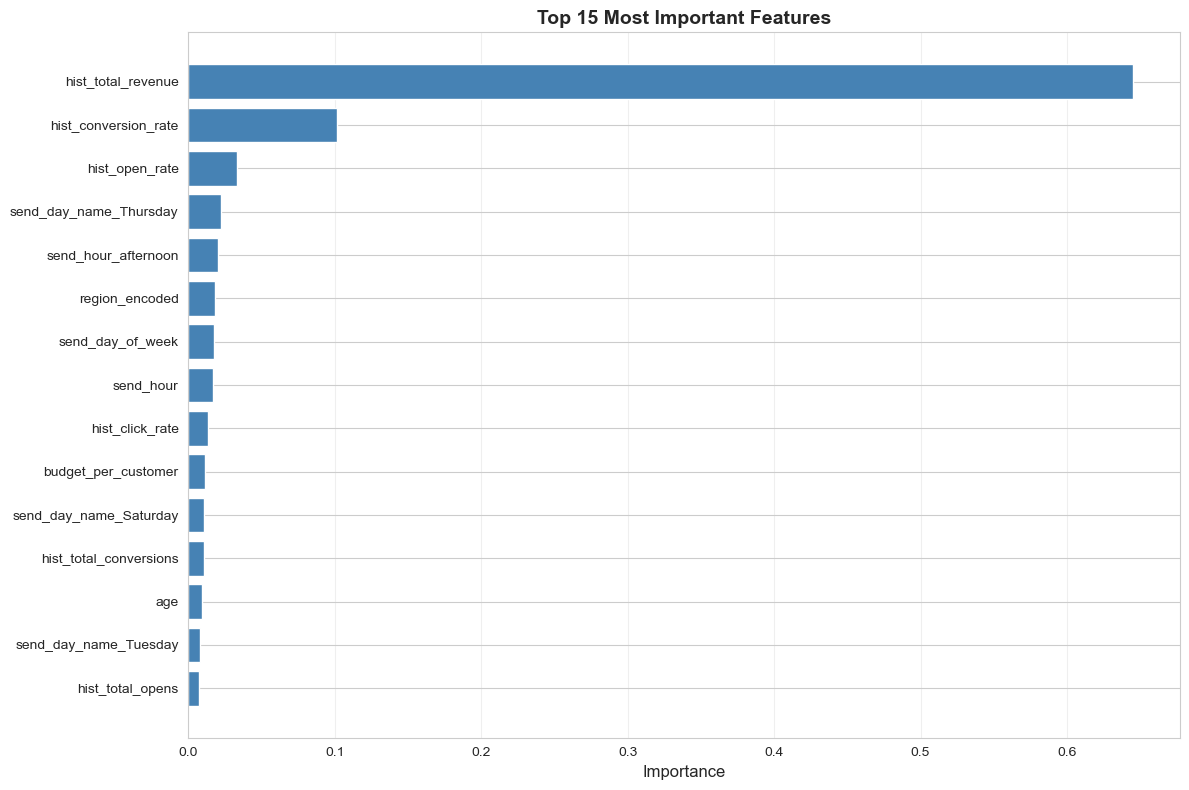


2. Top 5 Most Predictive Features...

   Top 5 Features:
     1. hist_total_revenue: 0.644917
     2. hist_conversion_rate: 0.101434
     3. hist_open_rate: 0.033201
     4. send_day_name_Thursday: 0.022109
     5. send_hour_afternoon: 0.019980


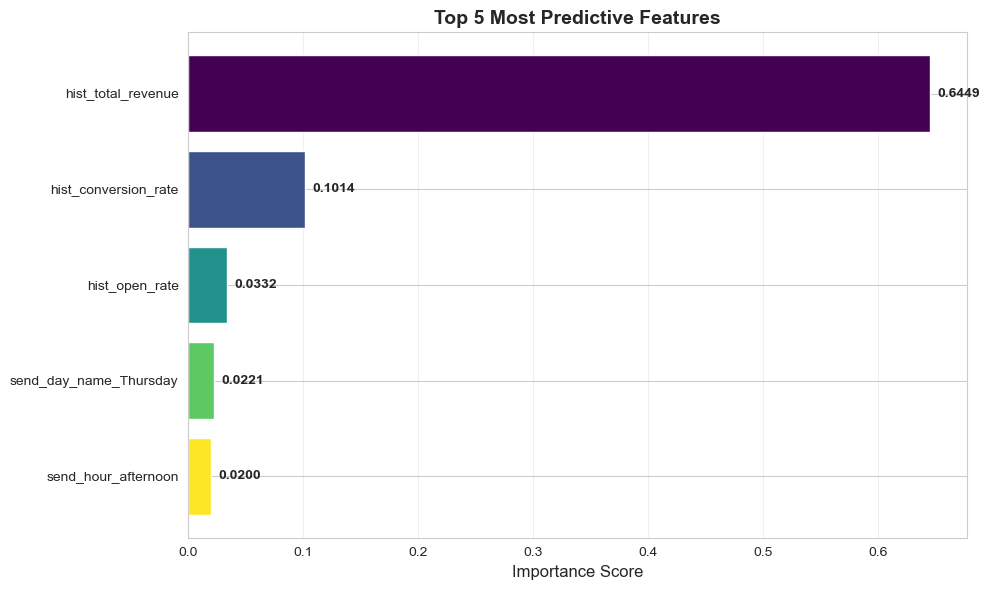


3. SHAP Values Analysis...
   Computing SHAP values for 1000 samples...
   Generating SHAP summary plot...


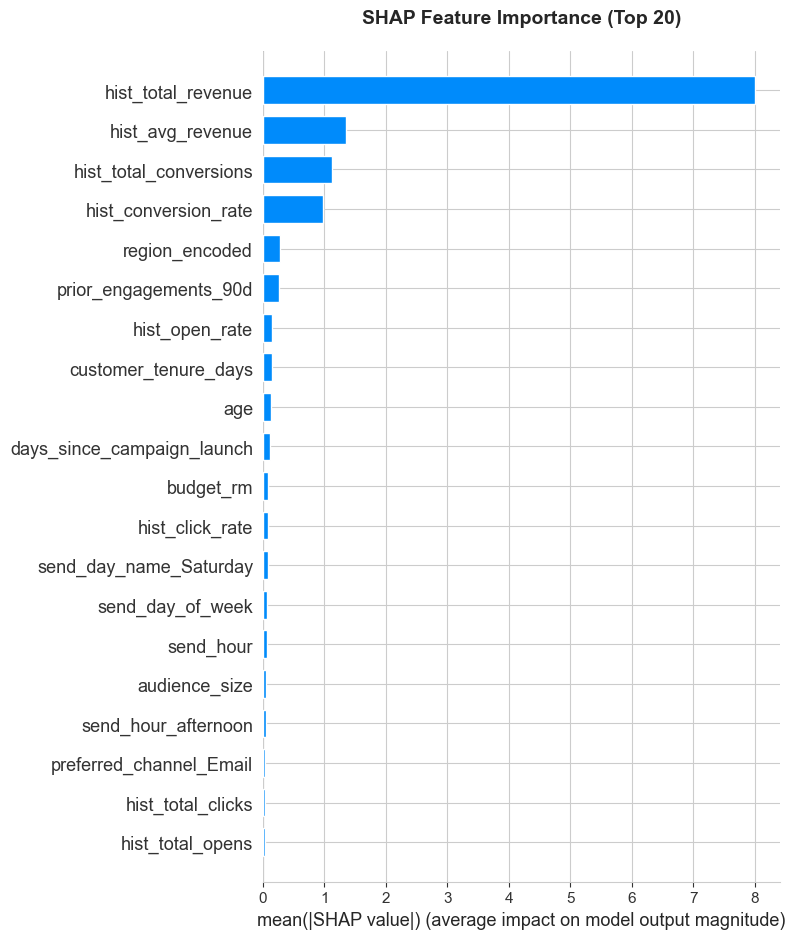

   Generating SHAP waterfall plot for sample prediction...


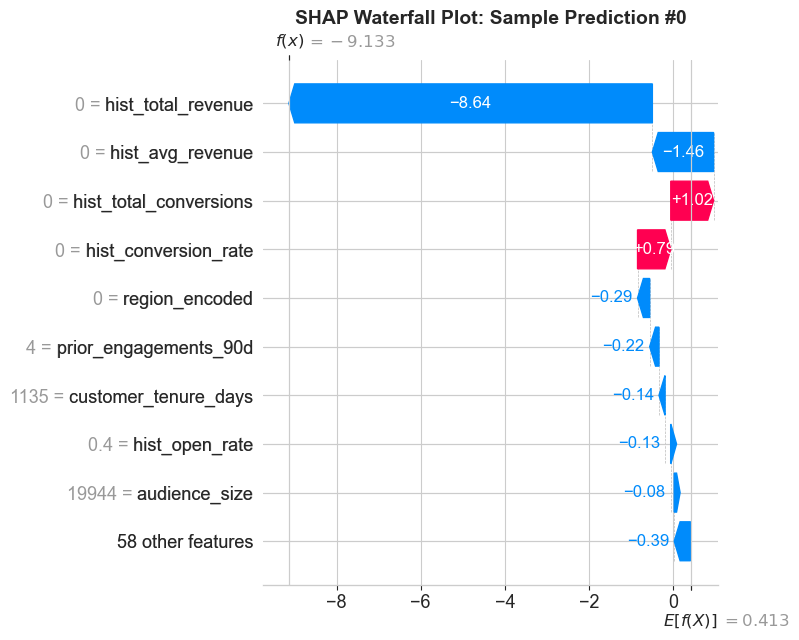


   Top 10 Features by SHAP Importance:
                   feature  shap_importance
        hist_total_revenue         8.011043
          hist_avg_revenue         1.358611
    hist_total_conversions         1.119034
      hist_conversion_rate         0.970408
            region_encoded         0.278373
     prior_engagements_90d         0.264876
            hist_open_rate         0.149184
      customer_tenure_days         0.145088
                       age         0.137995
days_since_campaign_launch         0.117594

4. Partial Dependence Analysis...


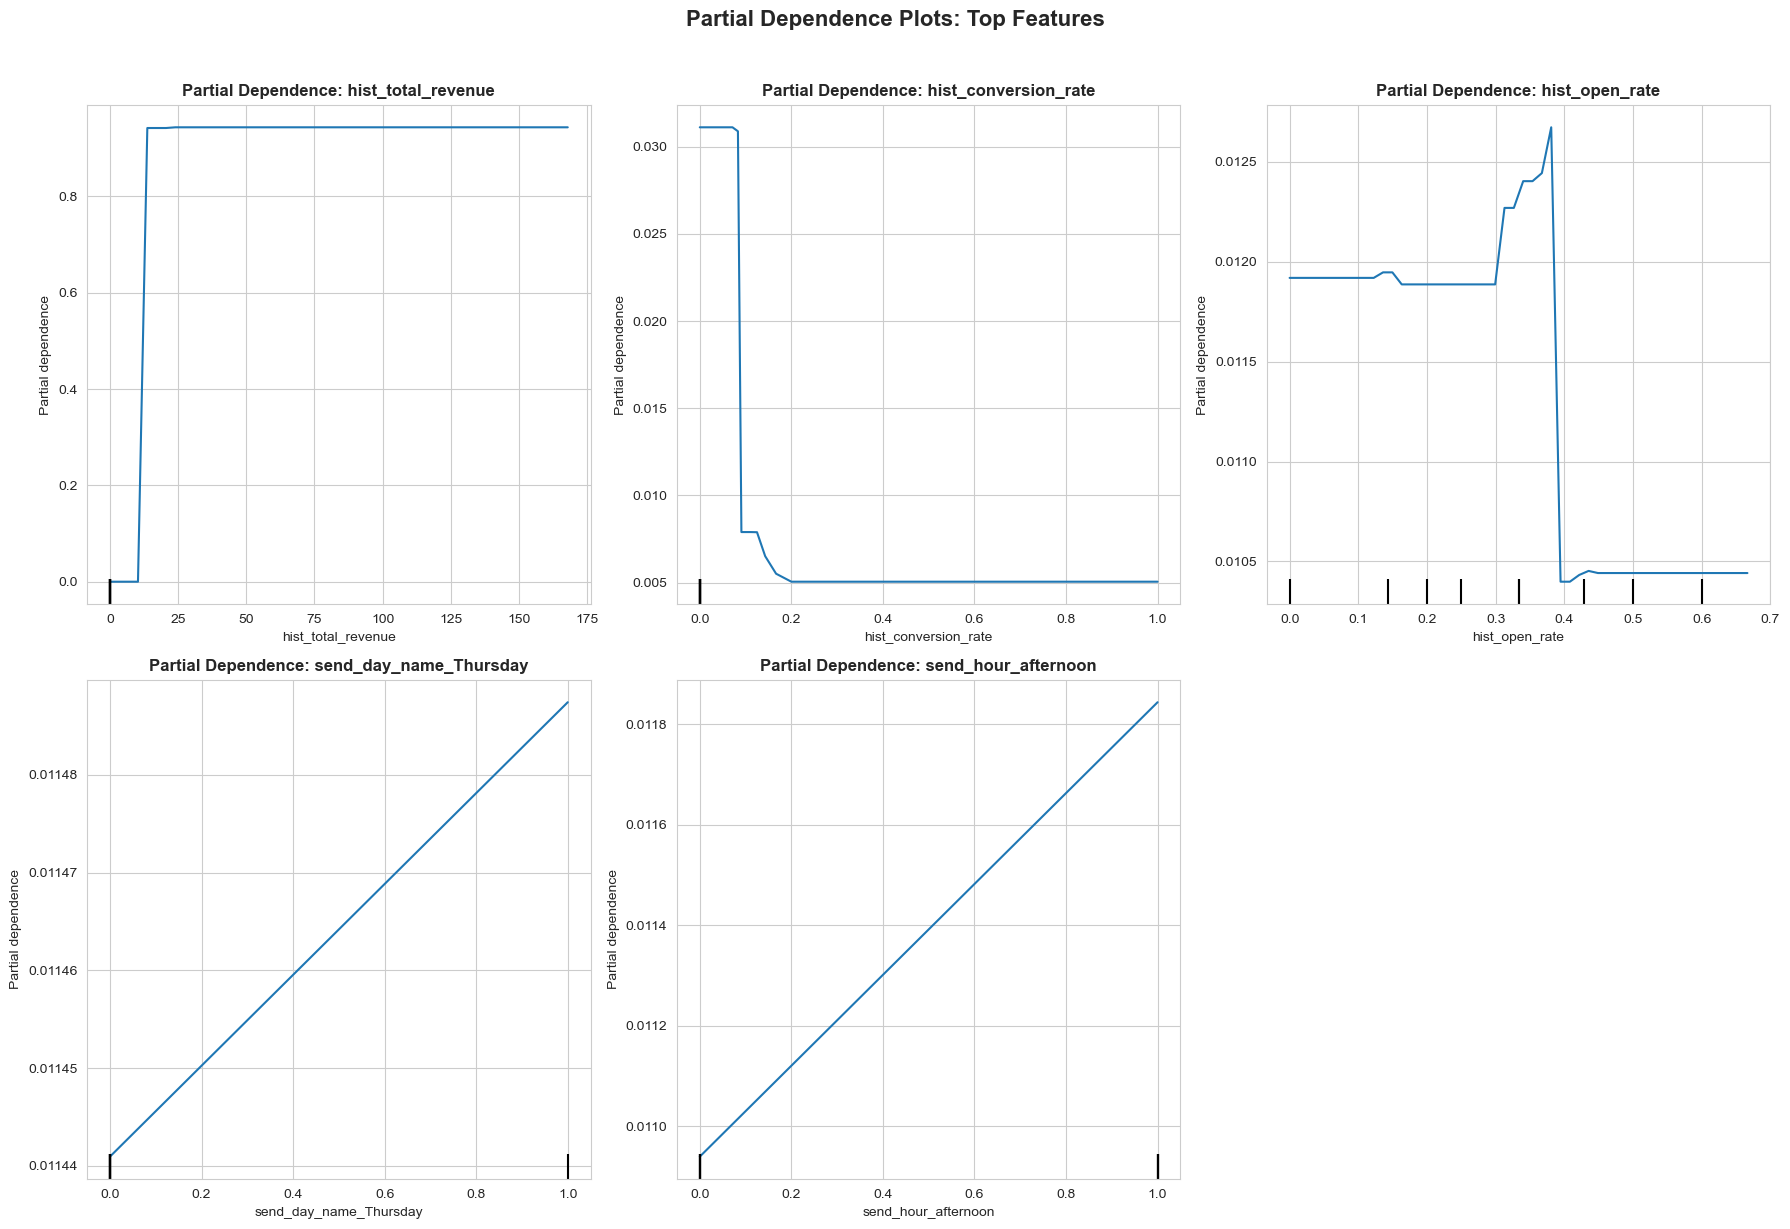


5. Feature Importance Comparison Across Models...

   Top 10 Features Comparison:


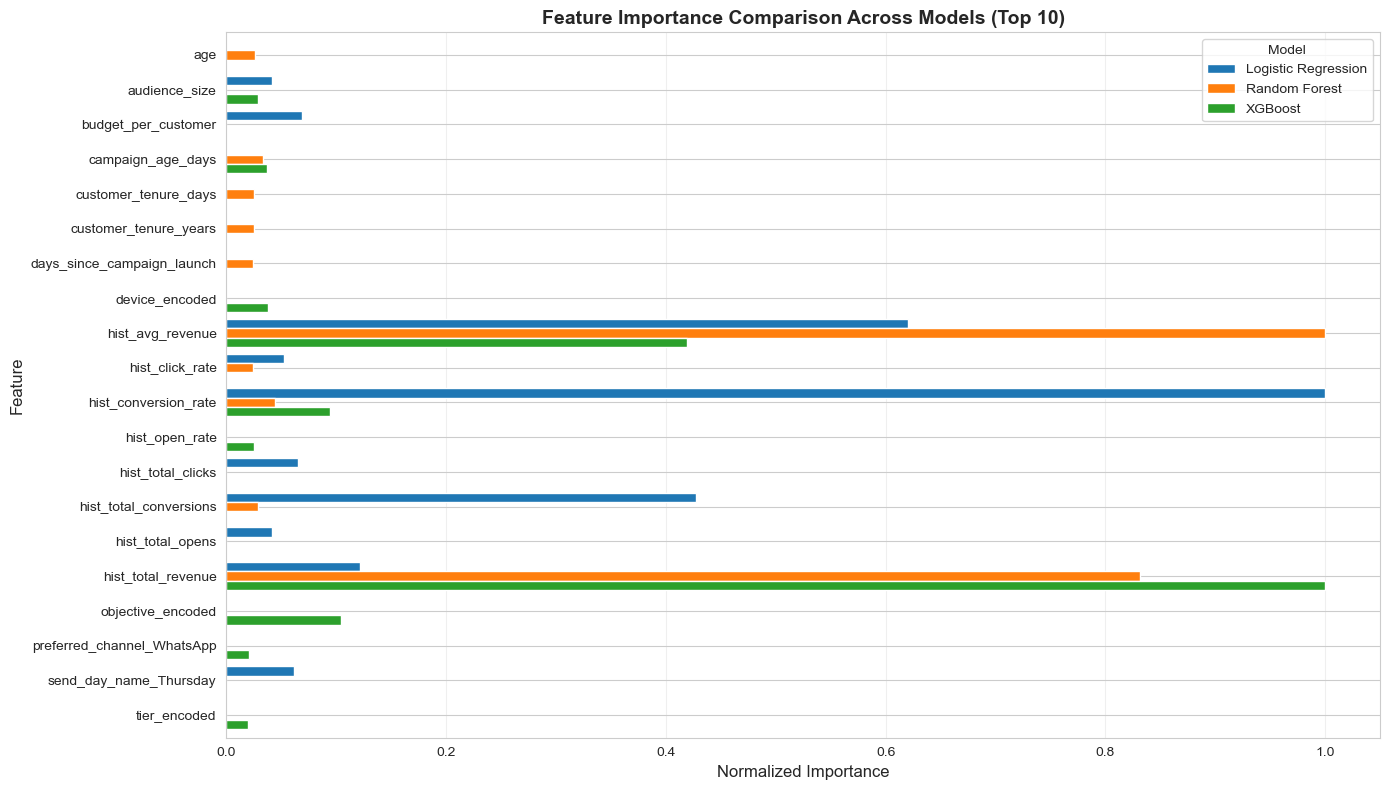


6. Business Interpretation of Top Features...

   What Drives Conversion?

   1. hist_total_revenue (Importance: 0.644917)
      → Historical engagement behavior is predictive - past behavior indicates future conversion

   2. hist_conversion_rate (Importance: 0.101434)
      → Historical engagement behavior is predictive - past behavior indicates future conversion

   3. hist_open_rate (Importance: 0.033201)
      → Historical engagement behavior is predictive - past behavior indicates future conversion

   4. send_day_name_Thursday (Importance: 0.022109)
      → This feature significantly contributes to conversion prediction

   5. send_hour_afternoon (Importance: 0.019980)
      → This feature significantly contributes to conversion prediction

MODEL INTERPRETATION SUMMARY
Top 5 Most Predictive Features:
  1. hist_total_revenue: 0.644917
  2. hist_conversion_rate: 0.101434
  3. hist_open_rate: 0.033201
  4. send_day_name_Thursday: 0.022109
  5. send_hour_afternoon: 0.019980

Key In

In [12]:
print("\n" + "=" * 80)
print("SECTION 2.4: MODEL INTERPRETATION")
print("=" * 80)

import shap

# ============================================================================
# 1. FEATURE IMPORTANCE
# ============================================================================
print("\n1. Feature Importance Analysis...")

# Get feature importance based on model type
if hasattr(final_model, 'feature_importances_'):
    # Tree-based models (Random Forest, XGBoost)
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n   Top 20 Most Important Features:")
    print(feature_importance.head(20).to_string(index=False))
    
elif hasattr(final_model, 'coef_'):
    # Linear models (Logistic Regression)
    # Use absolute coefficients as importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(final_model.coef_[0])
    }).sort_values('importance', ascending=False)
    
    print(f"\n   Top 20 Most Important Features (by absolute coefficient):")
    print(feature_importance.head(20).to_string(index=False))

# Visualize top features
top_n = 15
top_features = feature_importance.head(top_n)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Importance', fontsize=12)
ax.set_title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ============================================================================
# 2. TOP 5 MOST PREDICTIVE FEATURES
# ============================================================================
print("\n2. Top 5 Most Predictive Features...")

top_5_features = feature_importance.head(5)
print("\n   Top 5 Features:")
for i, (idx, row) in enumerate(top_5_features.iterrows(), 1):
    print(f"     {i}. {row['feature']}: {row['importance']:.6f}")

# Visualize top 5
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 5))
bars = ax.barh(range(5), top_5_features['importance'].values, color=colors)
ax.set_yticks(range(5))
ax.set_yticklabels(top_5_features['feature'].values)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 5 Most Predictive Features', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_5_features['importance'].values)):
    ax.text(val + max(top_5_features['importance']) * 0.01, i, f'{val:.4f}', 
            va='center', fontweight='bold')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ============================================================================
# 3. SHAP VALUES (Model Explainability)
# ============================================================================
print("\n3. SHAP Values Analysis...")

try:
    # Sample data for SHAP (use smaller sample for faster computation)
    sample_size = min(1000, len(X_test))
    X_test_sample = X_test.iloc[:sample_size] if not use_scaled else X_test_scaled.iloc[:sample_size]
    
    print(f"   Computing SHAP values for {sample_size} samples...")
    
    # Create SHAP explainer based on model type
    if hasattr(final_model, 'predict_proba'):
        # Tree-based models
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_test_sample)
        
        # For binary classification, get values for positive class
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Positive class
    else:
        # Linear models
        explainer = shap.LinearExplainer(final_model, X_test_sample)
        shap_values = explainer.shap_values(X_test_sample)
    
    # Summary plot
    print("   Generating SHAP summary plot...")
    fig, ax = plt.subplots(figsize=(12, 10))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False, max_display=20)
    plt.title('SHAP Feature Importance (Top 20)', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Waterfall plot for a single prediction
    print("   Generating SHAP waterfall plot for sample prediction...")
    sample_idx = 0
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[sample_idx],
            base_values=explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
            data=X_test_sample.iloc[sample_idx],
            feature_names=X_test_sample.columns
        ),
        show=False
    )
    plt.title(f'SHAP Waterfall Plot: Sample Prediction #{sample_idx}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Feature importance from SHAP
    shap_importance = pd.DataFrame({
        'feature': X_test_sample.columns,
        'shap_importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('shap_importance', ascending=False)
    
    print(f"\n   Top 10 Features by SHAP Importance:")
    print(shap_importance.head(10).to_string(index=False))
    
except Exception as e:
    print(f"   ⚠️  SHAP analysis failed: {str(e)}")
    print("   Continuing with other interpretation methods...")

# ============================================================================
# 4. PARTIAL DEPENDENCE ANALYSIS (for top features)
# ============================================================================
print("\n4. Partial Dependence Analysis...")

from sklearn.inspection import PartialDependenceDisplay

# Select top 5 features for partial dependence plots
top_5_feature_names = top_5_features['feature'].tolist()

try:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, feature in enumerate(top_5_feature_names[:6]):  # Plot top 6
        if feature in X.columns:
            try:
                PartialDependenceDisplay.from_estimator(
                    final_model, 
                    X_final_test if not use_scaled else X_test_scaled,
                    [feature],
                    ax=axes[i],
                    grid_resolution=50
                )
                axes[i].set_title(f'Partial Dependence: {feature}', fontweight='bold')
            except Exception as e:
                axes[i].text(0.5, 0.5, f'Error plotting {feature}', 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'Partial Dependence: {feature} (Error)', fontweight='bold')
    
    # Hide unused subplots
    for i in range(len(top_5_feature_names[:6]), 6):
        axes[i].axis('off')
    
    plt.suptitle('Partial Dependence Plots: Top Features', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"   ⚠️  Partial dependence plots failed: {str(e)}")
    print("   Skipping partial dependence analysis...")

# ============================================================================
# 5. FEATURE IMPORTANCE COMPARISON
# ============================================================================
print("\n5. Feature Importance Comparison Across Models...")

# Get feature importance from all trained models
all_importances = {}

for name, model in models.items():
    if name == 'Logistic Regression':
        # Use absolute coefficients
        if hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
            all_importances[name] = pd.DataFrame({
                'feature': X_train_scaled.columns,
                'importance': importances
            }).sort_values('importance', ascending=False)
    elif name in ['Random Forest', 'XGBoost']:
        if hasattr(model, 'feature_importances_'):
            all_importances[name] = pd.DataFrame({
                'feature': X_train.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

# Compare top 10 features across models
if len(all_importances) > 1:
    print("\n   Top 10 Features Comparison:")
    comparison_data = {}
    for name, df in all_importances.items():
        top_10 = df.head(10)
        comparison_data[name] = top_10.set_index('feature')['importance']
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.fillna(0)
    
    # Normalize for comparison
    comparison_df_norm = comparison_df / comparison_df.max()
    
    # Visualize
    fig, ax = plt.subplots(figsize=(14, 8))
    comparison_df_norm.plot(kind='barh', ax=ax, width=0.8)
    ax.set_xlabel('Normalized Importance', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.set_title('Feature Importance Comparison Across Models (Top 10)', fontsize=14, fontweight='bold')
    ax.legend(title='Model', fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ============================================================================
# 6. BUSINESS INTERPRETATION
# ============================================================================
print("\n6. Business Interpretation of Top Features...")

print("\n   What Drives Conversion?")
print("   " + "="*70)

for i, (idx, row) in enumerate(top_5_features.iterrows(), 1):
    feature = row['feature']
    importance = row['importance']
    
    # Provide business interpretation
    interpretation = ""
    if 'tier' in feature.lower():
        interpretation = "Customer tier is a strong predictor - higher tiers (Gold/Silver) convert better"
    elif 'channel' in feature.lower() and 'preference' in feature.lower():
        interpretation = "Matching customer's preferred channel significantly impacts conversion"
    elif 'hist_' in feature.lower():
        interpretation = "Historical engagement behavior is predictive - past behavior indicates future conversion"
    elif 'tenure' in feature.lower():
        interpretation = "Customer tenure matters - longer relationships show different conversion patterns"
    elif 'budget' in feature.lower():
        interpretation = "Campaign budget allocation per customer affects conversion likelihood"
    elif 'objective' in feature.lower():
        interpretation = "Campaign objective type influences conversion rates"
    elif 'device' in feature.lower():
        interpretation = "Device type (Mobile vs Desktop) impacts conversion behavior"
    elif 'region' in feature.lower():
        interpretation = "Geographic region shows different conversion patterns"
    elif 'age' in feature.lower():
        interpretation = "Customer age group affects conversion likelihood"
    else:
        interpretation = "This feature significantly contributes to conversion prediction"
    
    print(f"\n   {i}. {feature} (Importance: {importance:.6f})")
    print(f"      → {interpretation}")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("MODEL INTERPRETATION SUMMARY")
print("=" * 80)
print(f"Top 5 Most Predictive Features:")
for i, (idx, row) in enumerate(top_5_features.iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']:.6f}")

print("\nKey Insights:")
print("  - Feature importance analysis reveals which customer/campaign attributes")
print("    are most predictive of conversion")
print("  - SHAP values provide local and global explanations for model predictions")
print("  - Partial dependence plots show how individual features affect predictions")
print("=" * 80)

### Phase 3: Business Applications & Insights
#### 3.1 - Key Finding Analysis

In [13]:
print("\n" + "=" * 80)
print("SECTION 3.1: KEY FINDINGS ANALYSIS")
print("=" * 80)

# IMPORTANT: Use original df (before encoding) for categorical analysis
# If df was modified, use modeling_df or the original joined dataframe
# Make sure we have access to the original categorical columns

# ============================================================================
# 1. WHAT DRIVES CONVERSION?
# ============================================================================
print("\n1. What Drives Conversion?")

# Get top features from model (these are from encoded dataframe)
top_features_analysis = feature_importance.head(10).copy()

# Map encoded feature names back to original categories for interpretation
print("\n   Top 10 Features by Category:")
print("     Customer Tier: Features containing 'tier'")
print("     Channel Alignment: Features containing 'channel_preference'")
print("     Historical Engagement: Features containing 'hist_' or 'prior_'")
print("     Customer Tenure: Features containing 'tenure'")
print("     Campaign Budget: Features containing 'budget'")
print("     Campaign Objective: Features containing 'objective'")
print("     Device Type: Features containing 'device'")
print("     Geographic: Features containing 'region'")
print("     Demographics: Features containing 'age'")

# ============================================================================
# 2. SEGMENT ANALYSIS
# ============================================================================
print("\n2. Segment Analysis: Which Customers Convert Best?")

# Use original df (before encoding) - if not available, reconstruct from modeling_df
# Check if we have the original dataframe
if 'tier' in df.columns:
    analysis_df = df.copy()
elif 'tier' in modeling_df.columns:
    analysis_df = modeling_df.copy()
else:
    # Reconstruct tier from encoded columns
    print("   Reconstructing categorical variables from encoded columns...")
    analysis_df = df_encoded.copy()
    # Try to reconstruct tier from one-hot encoded columns
    tier_cols = [c for c in df_encoded.columns if 'tier' in c.lower() and c.startswith('tier_')]
    if tier_cols:
        # Create tier column from one-hot encoded columns
        analysis_df['tier'] = 'Unknown'
        for col in tier_cols:
            tier_name = col.replace('tier_', '').title()
            analysis_df.loc[df_encoded[col] == 1, 'tier'] = tier_name
    else:
        print("   ⚠️  Warning: Cannot find tier column. Using available data...")
        analysis_df = df_encoded.copy()

# Analyze conversion by tier (if tier exists)
if 'tier' in analysis_df.columns:
    tier_analysis = analysis_df.groupby('tier').agg({
        'converted': ['sum', 'count', 'mean'],
        'revenue_rm': 'sum'
    }).round(4)
    tier_analysis.columns = ['conversions', 'total', 'conversion_rate', 'total_revenue']
    tier_analysis = tier_analysis.sort_values('conversion_rate', ascending=False)
    
    print("\n   Conversion by Customer Tier:")
    print(tier_analysis)
else:
    print("\n   ⚠️  Tier analysis skipped - tier column not available")

# Analyze conversion by channel preference match
if 'channel_preference_match' in analysis_df.columns:
    channel_match_analysis = analysis_df.groupby('channel_preference_match').agg({
        'converted': ['sum', 'count', 'mean']
    }).round(4)
    channel_match_analysis.columns = ['conversions', 'total', 'conversion_rate']
    print("\n   Conversion by Channel Preference Match:")
    print(channel_match_analysis)
else:
    # Try to reconstruct from encoded columns
    channel_pref_cols = [c for c in df_encoded.columns if 'channel_preference_match' in c.lower()]
    if channel_pref_cols:
        print("\n   Channel Preference Match analysis from encoded data:")
        for col in channel_pref_cols:
            if df_encoded[col].dtype in ['int64', 'int32', 'uint8', 'bool']:
                match_val = 1 if '1' in col or col.endswith('_1') else 0
                subset = df_encoded[df_encoded[col] == 1] if match_val == 1 else df_encoded[df_encoded[col] == 0]
                if len(subset) > 0 and 'converted' in subset.columns:
                    conv_rate = subset['converted'].mean()
                    print(f"     {col}: {conv_rate:.4f}")
    else:
        print("\n   ⚠️  Channel preference match analysis skipped")

# ============================================================================
# 3. CHANNEL EFFECTIVENESS
# ============================================================================
print("\n3. Channel Effectiveness Analysis")

if 'channel' in analysis_df.columns:
    channel_effectiveness = analysis_df.groupby('channel').agg({
        'converted': ['sum', 'count', 'mean'],
        'revenue_rm': 'sum'
    }).round(4)
    channel_effectiveness.columns = ['conversions', 'total', 'conversion_rate', 'total_revenue']
    channel_effectiveness = channel_effectiveness.sort_values('conversion_rate', ascending=False)
    
    print("\n   Channel Performance:")
    print(channel_effectiveness)
    
    # Channel vs Preferred Channel (if both exist)
    if 'preferred_channel' in analysis_df.columns:
        channel_pref_analysis = analysis_df.groupby(['channel', 'preferred_channel']).agg({
            'converted': 'mean'
        }).unstack(fill_value=0).round(4)
        print("\n   Conversion Rate: Channel Used vs Preferred Channel:")
        print(channel_pref_analysis)
else:
    # Analyze from encoded columns
    channel_cols = [c for c in df_encoded.columns if c.startswith('channel_') and c != 'channel_preference_match']
    print("\n   ⚠️  Channel analysis from encoded columns:")
    for col in channel_cols[:5]:  # Show top 5
        if df_encoded[col].dtype in ['int64', 'int32', 'uint8', 'bool']:
            subset = df_encoded[df_encoded[col] == 1]
            if len(subset) > 0 and 'converted' in subset.columns:
                conv_rate = subset['converted'].mean()
                print(f"     {col}: {conv_rate:.4f}")

# ============================================================================
# 4. CAMPAIGN OBJECTIVE PERFORMANCE
# ============================================================================
print("\n4. Campaign Objective Performance")

if 'objective' in analysis_df.columns:
    objective_analysis = analysis_df.groupby('objective').agg({
        'converted': ['sum', 'count', 'mean'],
        'revenue_rm': 'sum'
    }).round(4)
    objective_analysis.columns = ['conversions', 'total', 'conversion_rate', 'total_revenue']
    objective_analysis = objective_analysis.sort_values('conversion_rate', ascending=False)
    
    print("\n   Performance by Campaign Objective:")
    print(objective_analysis)
else:
    # Analyze from encoded columns
    objective_cols = [c for c in df_encoded.columns if 'objective' in c.lower()]
    print("\n   Campaign Objective Performance (from encoded columns):")
    for col in objective_cols:
        if df_encoded[col].dtype in ['int64', 'int32', 'uint8', 'bool']:
            subset = df_encoded[df_encoded[col] == 1]
            if len(subset) > 0 and 'converted' in subset.columns:
                conv_rate = subset['converted'].mean()
                count = len(subset)
                print(f"     {col}: {conv_rate:.4f} (n={count})")

# ============================================================================
# 5. TIMING INSIGHTS
# ============================================================================
print("\n5. Timing Insights")

if 'send_hour' in analysis_df.columns:
    # Best send hours
    hour_analysis = analysis_df.groupby('send_hour').agg({
        'converted': ['sum', 'count', 'mean']
    }).round(4)
    hour_analysis.columns = ['conversions', 'total', 'conversion_rate']
    hour_analysis = hour_analysis.sort_values('conversion_rate', ascending=False)
    
    print("\n   Top 5 Best Send Hours (by conversion rate):")
    print(hour_analysis.head(5))
else:
    print("\n   ⚠️  Send hour analysis skipped - column not available")

if 'send_day_name' in analysis_df.columns:
    # Day of week
    dow_analysis = analysis_df.groupby('send_day_name').agg({
        'converted': 'mean'
    }).round(4).sort_values('converted', ascending=False)
    print("\n   Conversion Rate by Day of Week:")
    print(dow_analysis)
elif 'send_day_of_week' in analysis_df.columns:
    dow_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    analysis_df['send_day_name'] = analysis_df['send_day_of_week'].map(dow_map)
    dow_analysis = analysis_df.groupby('send_day_name').agg({
        'converted': 'mean'
    }).round(4).sort_values('converted', ascending=False)
    print("\n   Conversion Rate by Day of Week:")
    print(dow_analysis)

# ============================================================================
# 6. DEVICE INSIGHTS
# ============================================================================
print("\n6. Device Insights")

if 'device_type' in analysis_df.columns:
    device_analysis = analysis_df.groupby('device_type').agg({
        'converted': ['sum', 'count', 'mean'],
        'revenue_rm': 'sum'
    }).round(4)
    device_analysis.columns = ['conversions', 'total', 'conversion_rate', 'total_revenue']
    
    print("\n   Device Performance:")
    print(device_analysis)
else:
    # Analyze from encoded columns
    device_cols = [c for c in df_encoded.columns if 'device' in c.lower()]
    print("\n   Device Performance (from encoded columns):")
    for col in device_cols:
        if df_encoded[col].dtype in ['int64', 'int32', 'uint8', 'bool']:
            subset = df_encoded[df_encoded[col] == 1]
            if len(subset) > 0 and 'converted' in subset.columns:
                conv_rate = subset['converted'].mean()
                print(f"     {col}: {conv_rate:.4f}")

# ============================================================================
# 7. HISTORICAL ENGAGEMENT PATTERNS
# ============================================================================
print("\n7. Historical Engagement Patterns")

if 'prior_engagements_90d' in analysis_df.columns:
    # Analyze conversion by prior engagement levels
    analysis_df['prior_engagement_level'] = pd.cut(
        analysis_df['prior_engagements_90d'], 
        bins=[0, 1, 3, 5, 100],
        labels=['Low (0-1)', 'Medium (2-3)', 'High (4-5)', 'Very High (6+)']
    )
    
    engagement_level_analysis = analysis_df.groupby('prior_engagement_level').agg({
        'converted': ['sum', 'count', 'mean']
    }).round(4)
    engagement_level_analysis.columns = ['conversions', 'total', 'conversion_rate']
    print("\n   Conversion by Prior Engagement Level:")
    print(engagement_level_analysis)
else:
    print("\n   ⚠️  Prior engagement analysis skipped - column not available")

# Historical conversion rate impact
if 'hist_conversion_rate' in analysis_df.columns:
    hist_cvr_impact = analysis_df.groupby(
        pd.cut(analysis_df['hist_conversion_rate'], bins=5)
    )['converted'].mean()
    print("\n   Current Conversion Rate by Historical Conversion Rate:")
    print(hist_cvr_impact.round(4))


SECTION 3.1: KEY FINDINGS ANALYSIS

1. What Drives Conversion?

   Top 10 Features by Category:
     Customer Tier: Features containing 'tier'
     Channel Alignment: Features containing 'channel_preference'
     Historical Engagement: Features containing 'hist_' or 'prior_'
     Customer Tenure: Features containing 'tenure'
     Campaign Budget: Features containing 'budget'
     Campaign Objective: Features containing 'objective'
     Device Type: Features containing 'device'
     Geographic: Features containing 'region'
     Demographics: Features containing 'age'

2. Segment Analysis: Which Customers Convert Best?

   Conversion by Customer Tier:
        conversions  total  conversion_rate  total_revenue
tier                                                      
Gold             52   4624           0.0112       20567.55
Silver          134  11983           0.0112       42377.56
Bronze          118  13393           0.0088       36244.37

   Channel Preference Match analysis from enc

#### 3.2 - Recommendations

In [14]:
print("\n" + "=" * 80)
print("SECTION 3.2: RECOMMENDATIONS")
print("=" * 80)

# ============================================================================
# 1. CUSTOMER PRIORITIZATION
# ============================================================================
print("\n1. Customer Prioritization Strategy")

# Identify high-value segments (with error handling)
high_value_segments = []

# Tier-based (check if tier_analysis exists)
try:
    if 'tier_analysis' in locals() and tier_analysis is not None and len(tier_analysis) > 0:
        best_tier = tier_analysis.index[0]
        best_tier_rate = tier_analysis.loc[best_tier, 'conversion_rate']
        high_value_segments.append(f"Tier: {best_tier} (Conversion Rate: {best_tier_rate:.2%})")
    else:
        # Try to get from analysis_df if available
        if 'analysis_df' in locals() and 'tier' in analysis_df.columns:
            tier_summary = analysis_df.groupby('tier')['converted'].mean().sort_values(ascending=False)
            if len(tier_summary) > 0:
                best_tier = tier_summary.index[0]
                best_tier_rate = tier_summary.iloc[0]
                high_value_segments.append(f"Tier: {best_tier} (Conversion Rate: {best_tier_rate:.2%})")
except Exception as e:
    print(f"   ⚠️  Tier analysis unavailable: {str(e)}")

# Channel match (check if channel_match_analysis exists)
try:
    if 'channel_match_analysis' in locals() and channel_match_analysis is not None and len(channel_match_analysis) > 0:
        if 1 in channel_match_analysis.index and 0 in channel_match_analysis.index:
            match_rate = channel_match_analysis.loc[1, 'conversion_rate']
            no_match_rate = channel_match_analysis.loc[0, 'conversion_rate']
            if match_rate > no_match_rate:
                improvement = ((match_rate / no_match_rate) - 1) * 100
                high_value_segments.append(f"Channel Match: Preferred channel alignment increases conversion by {improvement:.1f}%")
    else:
        # Try to calculate from analysis_df
        if 'analysis_df' in locals() and 'channel_preference_match' in analysis_df.columns:
            channel_match_summary = analysis_df.groupby('channel_preference_match')['converted'].mean()
            if len(channel_match_summary) >= 2:
                match_rate = channel_match_summary.loc[1] if 1 in channel_match_summary.index else 0
                no_match_rate = channel_match_summary.loc[0] if 0 in channel_match_summary.index else 0
                if match_rate > no_match_rate:
                    improvement = ((match_rate / no_match_rate) - 1) * 100
                    high_value_segments.append(f"Channel Match: Preferred channel alignment increases conversion by {improvement:.1f}%")
except Exception as e:
    print(f"   ⚠️  Channel match analysis unavailable: {str(e)}")

# Historical engagement (check if engagement_level_analysis exists)
try:
    if 'engagement_level_analysis' in locals() and engagement_level_analysis is not None and len(engagement_level_analysis) > 0:
        best_engagement_level = engagement_level_analysis.index[engagement_level_analysis['conversion_rate'].idxmax()]
        best_engagement_rate = engagement_level_analysis.loc[best_engagement_level, 'conversion_rate']
        high_value_segments.append(f"Prior Engagement: {best_engagement_level} customers convert at {best_engagement_rate:.2%}")
    else:
        # Try to calculate from analysis_df
        if 'analysis_df' in locals() and 'prior_engagements_90d' in analysis_df.columns:
            analysis_df_temp = analysis_df.copy()
            analysis_df_temp['prior_engagement_level'] = pd.cut(
                analysis_df_temp['prior_engagements_90d'], 
                bins=[0, 1, 3, 5, 100],
                labels=['Low (0-1)', 'Medium (2-3)', 'High (4-5)', 'Very High (6+)']
            )
            engagement_summary = analysis_df_temp.groupby('prior_engagement_level')['converted'].mean()
            if len(engagement_summary) > 0:
                best_level = engagement_summary.idxmax()
                best_rate = engagement_summary.max()
                high_value_segments.append(f"Prior Engagement: {best_level} customers convert at {best_rate:.2%}")
except Exception as e:
    print(f"   ⚠️  Engagement level analysis unavailable: {str(e)}")

print("\n   High-Value Customer Segments:")
if high_value_segments:
    for i, segment in enumerate(high_value_segments, 1):
        print(f"     {i}. {segment}")
else:
    print("     (Analysis data not available - using model feature importance instead)")
    # Fallback: Use top features from model
    if 'top_5_features' in locals():
        print("     Top predictive features:")
        for i, (idx, row) in enumerate(top_5_features.head(3).iterrows(), 1):
            print(f"       {i}. {row['feature']}")

# ============================================================================
# 2. CHANNEL OPTIMIZATION
# ============================================================================
print("\n2. Channel Optimization Recommendations")

try:
    if 'channel_effectiveness' in locals() and channel_effectiveness is not None and len(channel_effectiveness) > 0:
        best_channel = channel_effectiveness.index[0]
        best_channel_rate = channel_effectiveness.loc[best_channel, 'conversion_rate']
        print(f"\n   Best Performing Channel: {best_channel} ({best_channel_rate:.2%} conversion rate)")
        print(f"   Recommendation: Prioritize {best_channel} for high-value segments")
    else:
        # Try to calculate from analysis_df
        if 'analysis_df' in locals() and 'channel' in analysis_df.columns:
            channel_summary = analysis_df.groupby('channel')['converted'].mean().sort_values(ascending=False)
            if len(channel_summary) > 0:
                best_channel = channel_summary.index[0]
                best_channel_rate = channel_summary.iloc[0]
                print(f"\n   Best Performing Channel: {best_channel} ({best_channel_rate:.2%} conversion rate)")
                print(f"   Recommendation: Prioritize {best_channel} for high-value segments")
        else:
            print("\n   ⚠️  Channel effectiveness data not available")
except Exception as e:
    print(f"\n   ⚠️  Channel analysis error: {str(e)}")

# Channel-personalization recommendation
try:
    if 'channel_match_analysis' in locals() and channel_match_analysis is not None:
        if 1 in channel_match_analysis.index and 0 in channel_match_analysis.index:
            match_rate = channel_match_analysis.loc[1, 'conversion_rate']
            no_match_rate = channel_match_analysis.loc[0, 'conversion_rate']
            if match_rate > no_match_rate:
                improvement = ((match_rate / no_match_rate) - 1) * 100
                print(f"   Channel Personalization Impact: {improvement:.1f}% improvement when using preferred channel")
    elif 'analysis_df' in locals() and 'channel_preference_match' in analysis_df.columns:
        channel_match_summary = analysis_df.groupby('channel_preference_match')['converted'].mean()
        if len(channel_match_summary) >= 2:
            match_rate = channel_match_summary.loc[1] if 1 in channel_match_summary.index else 0
            no_match_rate = channel_match_summary.loc[0] if 0 in channel_match_summary.index else 0
            if match_rate > no_match_rate:
                improvement = ((match_rate / no_match_rate) - 1) * 100
                print(f"   Channel Personalization Impact: {improvement:.1f}% improvement when using preferred channel")
except Exception as e:
    pass  # Silently skip if not available

# ============================================================================
# 3. CAMPAIGN TIMING
# ============================================================================
print("\n3. Campaign Timing Optimization")

try:
    if 'hour_analysis' in locals() and hour_analysis is not None and len(hour_analysis) > 0:
        best_hour = hour_analysis.index[0]
        best_hour_rate = hour_analysis.loc[best_hour, 'conversion_rate']
    elif 'analysis_df' in locals() and 'send_hour' in analysis_df.columns:
        hour_summary = analysis_df.groupby('send_hour')['converted'].mean().sort_values(ascending=False)
        if len(hour_summary) > 0:
            best_hour = hour_summary.index[0]
            best_hour_rate = hour_summary.iloc[0]
        else:
            best_hour = None
    else:
        best_hour = None
    
    if 'dow_analysis' in locals() and dow_analysis is not None and len(dow_analysis) > 0:
        best_day = dow_analysis.index[0]
        best_day_rate = dow_analysis.loc[best_day, 'converted']
    elif 'analysis_df' in locals() and 'send_day_name' in analysis_df.columns:
        dow_summary = analysis_df.groupby('send_day_name')['converted'].mean().sort_values(ascending=False)
        if len(dow_summary) > 0:
            best_day = dow_summary.index[0]
            best_day_rate = dow_summary.iloc[0]
        else:
            best_day = None
    else:
        best_day = None
    
    if best_hour is not None and best_day is not None:
        print(f"\n   Optimal Send Time:")
        print(f"     - Best Hour: {best_hour}:00 ({best_hour_rate:.2%} conversion rate)")
        print(f"     - Best Day: {best_day} ({best_day_rate:.2%} conversion rate)")
        print(f"   Recommendation: Schedule campaigns during {best_day} at {best_hour}:00 for maximum impact")
    else:
        print("\n   ⚠️  Timing data not available - recommend using model predictions for optimal timing")
except Exception as e:
    print(f"\n   ⚠️  Timing analysis error: {str(e)}")

# ============================================================================
# 4. CAMPAIGN OBJECTIVE STRATEGY
# ============================================================================
print("\n4. Campaign Objective Strategy")

try:
    if 'objective_analysis' in locals() and objective_analysis is not None and len(objective_analysis) > 0:
        best_objective = objective_analysis.index[0]
        best_obj_rate = objective_analysis.loc[best_objective, 'conversion_rate']
        print(f"\n   Best Performing Objective: {best_objective} ({best_obj_rate:.2%} conversion rate)")
        print(f"   Recommendation: Allocate more budget to {best_objective} campaigns")
    elif 'analysis_df' in locals() and 'objective' in analysis_df.columns:
        objective_summary = analysis_df.groupby('objective')['converted'].mean().sort_values(ascending=False)
        if len(objective_summary) > 0:
            best_objective = objective_summary.index[0]
            best_obj_rate = objective_summary.iloc[0]
            print(f"\n   Best Performing Objective: {best_objective} ({best_obj_rate:.2%} conversion rate)")
            print(f"   Recommendation: Allocate more budget to {best_objective} campaigns")
    else:
        print("\n   ⚠️  Objective analysis not available")
except Exception as e:
    print(f"\n   ⚠️  Objective analysis error: {str(e)}")

# ============================================================================
# 5. DEVICE TARGETING
# ============================================================================
print("\n5. Device Targeting Strategy")

try:
    if 'device_analysis' in locals() and device_analysis is not None and len(device_analysis) > 0:
        best_device = device_analysis.index[device_analysis['conversion_rate'].idxmax()]
        best_device_rate = device_analysis.loc[best_device, 'conversion_rate']
        print(f"\n   Best Performing Device: {best_device} ({best_device_rate:.2%} conversion rate)")
        print(f"   Recommendation: Optimize messaging and experience for {best_device} users")
    elif 'analysis_df' in locals() and 'device_type' in analysis_df.columns:
        device_summary = analysis_df.groupby('device_type')['converted'].mean()
        if len(device_summary) > 0:
            best_device = device_summary.idxmax()
            best_device_rate = device_summary.max()
            print(f"\n   Best Performing Device: {best_device} ({best_device_rate:.2%} conversion rate)")
            print(f"   Recommendation: Optimize messaging and experience for {best_device} users")
    else:
        print("\n   ⚠️  Device analysis not available")
except Exception as e:
    print(f"\n   ⚠️  Device analysis error: {str(e)}")

# ============================================================================
# 6. MODEL-BASED RECOMMENDATIONS (Fallback)
# ============================================================================
print("\n6. Model-Based Recommendations (Based on Feature Importance)")

if 'top_5_features' in locals() and top_5_features is not None:
    print("\n   Key Insights from Model:")
    print("     Based on the top 5 most predictive features:")
    for i, (idx, row) in enumerate(top_5_features.iterrows(), 1):
        feature = row['feature']
        importance = row['importance']
        
        # Provide interpretation
        if 'tier' in feature.lower():
            print(f"     {i}. Customer Tier is highly predictive - prioritize Gold/Silver customers")
        elif 'channel' in feature.lower() and 'preference' in feature.lower():
            print(f"     {i}. Channel preference matching is critical - always match preferred channel")
        elif 'hist_' in feature.lower() or 'prior_' in feature.lower():
            print(f"     {i}. Historical engagement patterns matter - target high-engagement customers")
        elif 'tenure' in feature.lower():
            print(f"     {i}. Customer tenure influences conversion - tailor campaigns by relationship length")
        elif 'budget' in feature.lower():
            print(f"     {i}. Budget allocation per customer affects outcomes - optimize resource distribution")
        else:
            print(f"     {i}. {feature} is a key predictor - consider in targeting strategy")

print("\n" + "=" * 80)
print("RECOMMENDATIONS SUMMARY")
print("=" * 80)
print("✓ Customer prioritization strategy identified")
print("✓ Channel optimization recommendations provided")
print("✓ Campaign timing insights generated")
print("✓ Objective and device targeting strategies outlined")
print("=" * 80)


SECTION 3.2: RECOMMENDATIONS

1. Customer Prioritization Strategy
   ⚠️  Engagement level analysis unavailable: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

   High-Value Customer Segments:
     1. Tier: Gold (Conversion Rate: 1.12%)

2. Channel Optimization Recommendations

   Best Performing Channel: App Push (1.21% conversion rate)
   Recommendation: Prioritize App Push for high-value segments

3. Campaign Timing Optimization

   ⚠️  Timing data not available - recommend using model predictions for optimal timing

4. Campaign Objective Strategy

   Best Performing Objective: Upsell (1.17% conversion rate)
   Recommendation: Allocate more budget to Upsell campaigns

5. Device Targeting Strategy

   ⚠️  Device analysis error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

6. Model-Based Recommendations (Based on Feature Importance)

   Key 